In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import soundfile as sf
from scipy.signal import butter, filtfilt, hilbert, spectrogram, freqz, sosfiltfilt, find_peaks, sosfilt
from scipy.ndimage import gaussian_filter1d
from IPython.display import Audio, display

#### Testing JPM digital signal processing

In [ ]:
# load FLAC file
input_flac_file = "ManualRockMovements-1/audio/Nicole_091823-000100.flac"
data, samplerate = sf.read(input_flac_file)

# if stereo (more than one channel), keep only one channel
if data.ndim > 1:
    data = data[:,0] # keep the left channel, which in this case is the impact pipe

Gain Compensation

In [ ]:
preamp_gain_db = 23  # preamp gain in dB for this recording
linear_gain = 10**(preamp_gain_db / 20)
calibrated_data = data / linear_gain

print(f"Sampling Rate: {samplerate} Hz")
print(f"Original data shape: {data.shape}")
print(f"Linear gain factor: {linear_gain:.2f}")

# plot the raw and calibrated waveforms for verification
time = np.arange(len(data)) / samplerate
# note this took 2-minutes to run
plt.figure(figsize=(12, 6))
plt.plot(time, data, label="Raw Digital Data")
plt.plot(time, calibrated_data, label="Gain-Compensated Data")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Original vs. Gain-Compensated Waveform")
plt.legend(loc='upper right')
# saving instead of showing to avoid space usage issues
plt.savefig("calibration_plots/test/test_waveform_comparison.png", dpi=300)
plt.close()

Spectrogram (for frequency high and low cut selection)

In [ ]:
# commenting this out because it takes so long to run
#frequencies, times, Sxx = spectrogram(calibrated_data, samplerate, nperseg=2048)
#plt.figure(figsize=(15, 6))
#plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud')
#plt.colorbar(label='Intensity [dB]') 
#plt.ylabel('Frequency [Hz]')
#plt.xlabel('Time [sec]')
#plt.title('Acoustic Signal Spectrogram')
#plt.ylim([0, samplerate / 2])  # limit y-axis to Nyquist frequency
#plt.savefig("calibration_plots/test/test_spectrogram.png", dpi=300)
#plt.close()

Time averaged frequency spectrum

In [ ]:
frequencies, times, Sxx = spectrogram(calibrated_data, samplerate, nperseg=2048)

# average spectrum over time
cols = np.arange(len(times))
spec_avg = Sxx[:, cols].mean(axis=1)
spec_sm = gaussian_filter1d(spec_avg, 2) # smooth with gaussian filter; sigma=2

# plot the averaged and smoothed spectrum
plt.figure(figsize=(7,3.5))
plt.plot(frequencies, spec_sm, label="Smoothed avg spectrum")
plt.xlim(0, 2000)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title("Total Calibration Sample: Averaged Spectrum")
plt.tight_layout()
plt.savefig("calibration_plots/test/test_time_avg_spectrum.png", dpi=300)
plt.close()

FFT frequency spectrum

In [ ]:
# FFT-based frequency spectrum
fft_data = np.fft.fft(calibrated_data)
frequencies_fft = np.fft.fftfreq(len(calibrated_data), 1/samplerate)

# take only positive frequencies and convert to magnitude
positive_freq_mask = frequencies_fft >= 0
frequencies_fft = frequencies_fft[positive_freq_mask]
magnitude_spectrum = np.abs(fft_data[positive_freq_mask])
spec_sm_fft = gaussian_filter1d(magnitude_spectrum, 500)  # smooth with gaussian filter; sigma=500

# plot FFT-based averaged and smoothed spectrum
plt.figure(figsize=(7,3.5))
plt.plot(frequencies_fft, spec_sm_fft, label="Smoothed FFT spectrum")
plt.xlim(0, 2000)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title("Total Calibration Sample: FFT-Based Spectrum")
plt.tight_layout()
plt.savefig("calibration_plots/test/test_fft_spectrum.png", dpi=300)
plt.close()

Functions to select frequency band 

In [ ]:
def band_sos(low, high, fs, order=5):
    nyq = 0.5 * fs
    lown = max(low / nyq, 1e-6) # avoid 0 or negative
    highn = min(high / nyq, 0.999999) # avoid >1
    return butter(order, [lown := lown, highn], btype='band', output='sos') # bandpass filter

def apply_band_and_energy(x, fs, band, order=4):
    low, high = band 
    sos = band_sos(low, high, fs, order=order)
    y = sosfiltfilt(sos, x)
    # energy (RMS^2) overall and in sliding windows if desired
    energy = np.mean(y**2)
    return y, energy

def band_test_and_plot(x, fs, bands, event_window=None, quiet_window=None, nperseg=2048, noverlap=None):
    if noverlap is None:
        noverlap = nperseg // 2
    results = {}
    for band in bands:
        y, energy = apply_band_and_energy(x, fs, band)
        # compute spectrogram for plotting
        f, t, Sxx = spectrogram(y, fs=fs, window='hann', nperseg=nperseg, noverlap=noverlap, scaling='density', mode='magnitude')
        results[band] = {'y': y, 'energy': energy, 'f': f, 't': t, 'Sxx': Sxx}

    # compute event and quiet band energies if windows provided
    if event_window is not None:
        t0, t1 = event_window
        idx0 = int(t0 * fs); idx1 = int(t1 * fs)
    else:
        idx0, idx1 = 0, len(x)
    if quiet_window is not None:
        q0, q1 = quiet_window
        qidx0, qidx1 = int(q0*fs), int(q1*fs)
    else:
        # pick a quiet stretch before the event if possible
        qidx0, qidx1 = 0, min(int(0.5*fs), len(x))

    print("Band energy summary (mean squared) and event/quiet ratios:")
    eps = np.finfo(float).eps # small number to avoid div by 0
    for band, info in results.items():
        y = info['y'] # band-passed signal
        event_energy = np.mean(y[idx0:idx1]**2) # average power during event
        quiet_energy = np.median(y[qidx0:qidx1]**2)     # robust noise estimate
        quiet_energy = max(quiet_energy, eps)           # avoid division by 0
        ratio = event_energy / quiet_energy
        snr_db = 10.0 * np.log10(ratio)
        print(f"{band[0]:4.0f}-{band[1]:4.0f} Hz:"
            f" total {info['energy']:.3e},"
            f" event_power {event_energy:.3e},"
            f" quiet_power {quiet_energy:.3e},"
            f" ratio {ratio:.2f}, snr={snr_db:.1f} dB")

    # plot spectrograms side-by-side for visual comparison
    n = len(bands)
    plt.figure(figsize=(12, 3*n))
    for i, band in enumerate(bands, start=1):
        info = results[band]
        plt.subplot(n, 1, i)
        plt.pcolormesh(info['t'], info['f'], 10*np.log10(info['Sxx'] + 1e-12), shading='auto')
        plt.ylim(0, min(3000, fs/2))
        plt.title(f"Band {band[0]}-{band[1]} Hz spectrogram")
        plt.ylabel("Freq (Hz)")
        plt.colorbar(label='dB')
    plt.xlabel("Time (s)")
    plt.tight_layout()
    plt.show()

    return results

In [ ]:
bands = [(20,300), (700,1500), (20,2000)]
results = band_test_and_plot(calibrated_data, samplerate, bands, event_window=(35,850), quiet_window=(1100,1200))

Play filtered recordings for verification

In [ ]:
# play original
# normalize to avoid clipping
def play_array(x, fs, norm=True):
    xr = x / (np.max(np.abs(x)) + 1e-12) if norm else x
    display(Audio(xr, rate=fs))


play_array(calibrated_data, samplerate)

In [ ]:
# low band (20-200 Hz)
low = apply_band_and_energy(calibrated_data, samplerate, (20,200))[0] 
play_array(low, samplerate)

In [ ]:
# mid band (700-1500 Hz)
mid = apply_band_and_energy(calibrated_data, samplerate, (700,1500))[0]
play_array(mid, samplerate)

In [ ]:
# full band (20-2000 Hz)
full = apply_band_and_energy(calibrated_data, samplerate, (20,2000))[0]
play_array(full, samplerate)

### Band-Pass Filtering 

Filter Order Selection

In [14]:
def band_pass_filter(data, samplerate, low, high, order):
    nyquist = 0.5 * samplerate
    low = low / nyquist
    high = high / nyquist
    b, a = butter(order, [low, high], btype='band') # get filter coefficients
    filtered_data = filtfilt(b, a, data)
    return filtered_data

In [15]:
# plotting the filters
lowcut = 700       # low cutoff frequency (Hz)
highcut = 1500       # high cutoff frequency (Hz)
orders = [3, 4, 5, 6]  # filter orders to compare
nyquist = 0.5 * samplerate
plt.figure(figsize=(7, 4))

for order in orders:
    # get the filter coefficients
    b, a = butter(order, [lowcut / nyquist, highcut / nyquist], btype='band')
    # calculate the frequency response
    w, h = freqz(b, a, worN=2000) # worN determines the number of points at which to evaluate the response

    # convert angular frequency to Hz and magnitude to a linear scale (0-1)
    frequencies = w * samplerate / (2 * np.pi)
    magnitude_response = np.abs(h)

    # plot the magnitude response
    plt.plot(frequencies, magnitude_response, label=f'Order {order}')

# add vertical line at cutoff frequencies
plt.axvline(lowcut, color='gray', linestyle='--', label='Low Cutoff')
plt.axvline(highcut, color='gray', linestyle='--', label='High Cutoff')
plt.title('Butterworth Band-Pass Filter Frequency Response')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.grid(True)
plt.legend()
plt.xlim(0, 3000)  # Adjust x-axis limits to better visualize the passband
plt.ylim(0, 1.1)   # Adjust y-axis limits
plt.savefig("calibration_plots/test/test_bandpass_filter.png", dpi=300)
plt.close()

In [16]:
lowcut = 700  # low cutoff frequency in Hz
highcut = 1500 # high cutoff frequency in Hz

data_3 = band_pass_filter(calibrated_data, samplerate, lowcut, highcut, order=3)
data_4 = band_pass_filter(calibrated_data, samplerate, lowcut, highcut, order=4)
data_5 = band_pass_filter(calibrated_data, samplerate, lowcut, highcut, order=5)

In [17]:
# visualize the filtered signal
plt.figure(figsize=(12, 6))
plt.plot(time, calibrated_data, label="Original", color='orange', alpha=0.5)
plt.plot(time, data_3, label="Order 3", color='blue', alpha=0.5)
plt.plot(time, data_4, label="Order 4", color='green', alpha=0.5)
plt.plot(time, data_5, label="Order 5", color='red', alpha=0.5)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Band-Pass Filtered Signal")
plt.legend(loc='upper right')
plt.savefig("calibration_plots/test/test_bandpass_filtered_signal.png", dpi=300)
plt.close()

Subsample for noise detection

In [18]:
# individual impact - between 39 and 49 seconds
subsample = calibrated_data[int(39 * samplerate):int(49 * samplerate)]
sub3 = data_3[int(39 * samplerate):int(49 * samplerate)]
sub5 = data_5[int(39 * samplerate):int(49 * samplerate)]
subtime = np.arange(len(subsample)) / samplerate

In [19]:
# visualize the filtered signal
plt.figure(figsize=(20, 5))
plt.plot(subtime, subsample, label="Original", color='orange', alpha=0.7)
plt.plot(subtime, sub5, label="Order 5", color='red', alpha=0.6)

plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Band-Pass Filtered Signal")
plt.ylim(-0.01, 0.01)
plt.legend(loc='upper right')
plt.savefig("calibration_plots/test/test_subsample_bandpass_filtered_signal.png", dpi=300)
plt.close()

Filter Data and Amplify 

In [20]:
lowcut = 700  # low cutoff frequency in Hz
highcut = 1500 # high cutoff frequency in Hz

# first band-pass filter the entire calibrated data
filtered_data1 = band_pass_filter(calibrated_data, samplerate, lowcut, highcut, order=4)
filtered_data2 = filtered_data1 * 20

# second band-pass filter
filtered_data3 = band_pass_filter(filtered_data2, samplerate, lowcut, highcut, order=4)
filtered_data = filtered_data3 * 10

In [21]:
# visualize the filtered signal
plt.figure(figsize=(20, 5))
plt.plot(time, filtered_data2, label="Filtered (1st)", color='red', alpha=0.7)
plt.plot(time, filtered_data3, label="Filtered (2nd)", color='blue', alpha=0.7)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Band-Pass Filtered Signals (Without Amplification)")
plt.legend(loc='upper right')
twin = plt.twinx()
twin.plot(time, calibrated_data, label="Original", color='orange', alpha=0.5)

#plt.xlim(41.2, 42)  # zoom in to see details
plt.savefig("calibration_plots/test/test_bandpass_filtered_signals_full.png", dpi=300)
plt.close()

In [ ]:
# DELETING VARIABLES NOT NEEDED ANYMORE
del data, calibrated_data, data_3, data_4, data_5
del sub3, sub5, h, cols, fft_data, frequencies_fft, 
del magnitude_spectrum, spec_sm_fft, full, positive_freq_mask
del filtered_data1, filtered_data2, filtered_data3, lowcut, highcut
del orders, b, a, w, frequencies, times
del twin, spec_sm, spec_avg, magnitude_response, results, input_flac_file

### Envelope Detection

Subsample for envelope

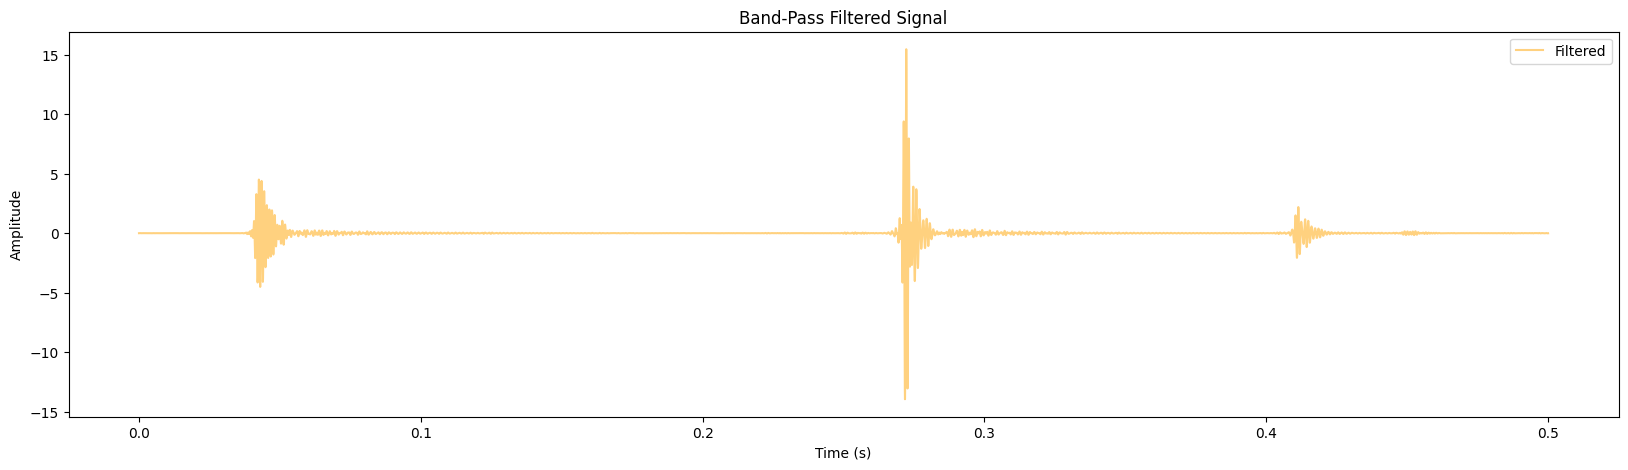

In [23]:
subsample = filtered_data[int(41.35 * samplerate):int(41.85* samplerate)]
subtime = np.arange(len(subsample)) / samplerate

# visualize the filtered signal
plt.figure(figsize=(20, 5))
plt.plot(subtime, subsample, label="Filtered", color='orange', alpha=0.5)

plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Band-Pass Filtered Signal")
#plt.ylim(-0.1, 0.1)
plt.legend(loc='upper right')
plt.show()

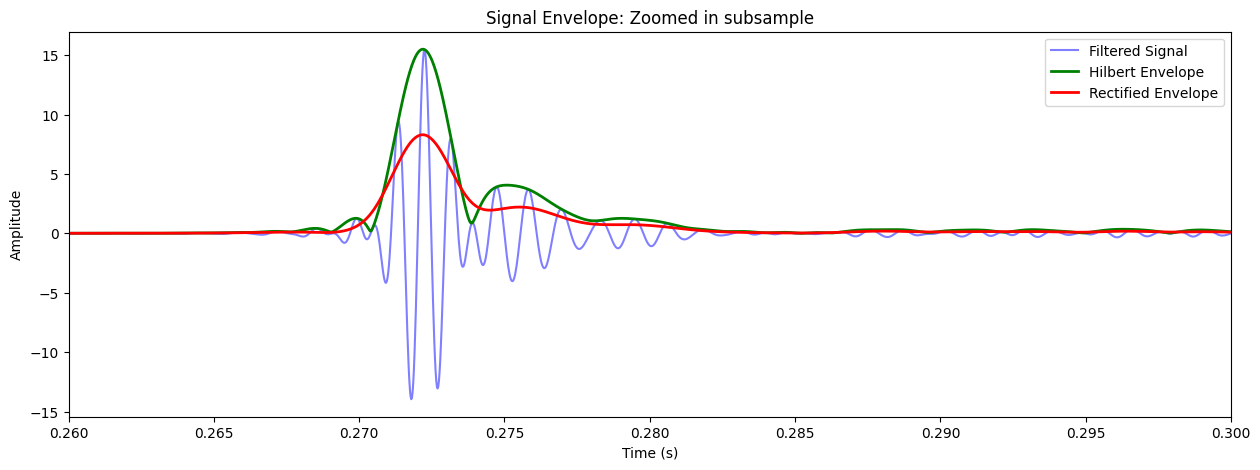

In [24]:
# using the hilbert transform 
analytic_signal = hilbert(subsample)
envelope_hilbert = np.abs(analytic_signal)

# using rectification and low-pass filter
cutoff_freq_envelope = 300 # # low low-pass filter to smooth the rectified signal
low_pass_cutoff = cutoff_freq_envelope / nyquist
b_lp, a_lp = butter(2, low_pass_cutoff, btype='low')
envelope_rectified = filtfilt(b_lp, a_lp, np.abs(subsample))

# visualize the envelopes
plt.figure(figsize=(15, 5))
plt.plot(subtime, subsample, 'b-', label='Filtered Signal', alpha=0.5)
plt.plot(subtime, envelope_hilbert, 'g-', linewidth=2, label='Hilbert Envelope')
plt.plot(subtime, envelope_rectified, 'r-', linewidth=2, label='Rectified Envelope')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Signal Envelope: Zoomed in subsample")
plt.legend()
plt.xlim(0.26, 0.3)
plt.savefig("calibration_plots/test/test_signal_envelopes_zoomed_single.png", dpi=300)
plt.show()


Full Sample

In [25]:
# using the hilbert transform 
analytic_signal = hilbert(filtered_data)
envelope_hilbert = np.abs(analytic_signal)

# using rectification and low-pass filter
cutoff_freq_envelope = 100 # # low low-pass filter to smooth the rectified signal
low_pass_cutoff = cutoff_freq_envelope / nyquist
b_lp, a_lp = butter(2, low_pass_cutoff, btype='low')
envelope_rectified = filtfilt(b_lp, a_lp, np.abs(filtered_data))

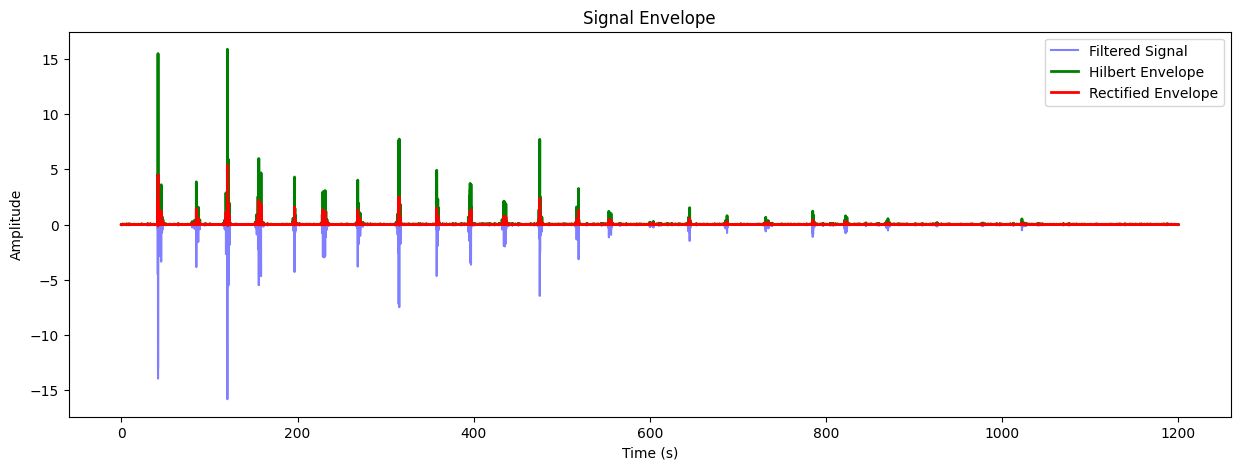

In [26]:
# visualize the envelopes
plt.figure(figsize=(15, 5))
plt.plot(time, filtered_data, 'b-', label='Filtered Signal', alpha=0.5)
plt.plot(time, envelope_hilbert, 'g-', linewidth=2, label='Hilbert Envelope')
plt.plot(time, envelope_rectified, 'r-', linewidth=2, label='Rectified Envelope')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Signal Envelope")
plt.legend(loc='upper right')
#plt.xlim(42.4, 42.7)
#plt.ylim(-5, 5)
plt.savefig("calibration_plots/test/test_signal_envelopes_full.png", dpi=300)
plt.show()


### Pulse counting and Rectangular waveform

Compute and plot the rectangular waveforms

In [27]:
# channel gains (relative multipliers) from 
gains = {
    6: 1,
    5: 4,
    4: 16,
    3: 64,
    2: 256,
    1: 1024
}

# voltage thresholds for impulse detection
lower_thresh = 2  # volts

# first column of results is the time index of detected impulses
rect_hilbert = pd.DataFrame({'time': time})
rect_rectified = pd.DataFrame({'time': time})

# loop over channels, apply gain, and detect impulses
# for hilbert envelope
for ch, gain in gains.items():
    amplified = envelope_hilbert * gain
    # create binary array: 1 if in threshold, else 0
    binary = ((amplified > lower_thresh)).astype(int)
    # convert to 5 V pulse
    rectangular = binary * 5
    rect_hilbert[f'ch{ch}'] = rectangular

# for rectified envelope
for ch, gain in gains.items():
    amplified = envelope_rectified * gain
    # create binary array: 1 if in threshold, else 0
    binary = ((amplified > lower_thresh)).astype(int)
    # convert to 5 V pulse
    rectangular = binary * 5
    rect_rectified[f'ch{ch}'] = rectangular

del amplified, binary, rectangular, ch, gain

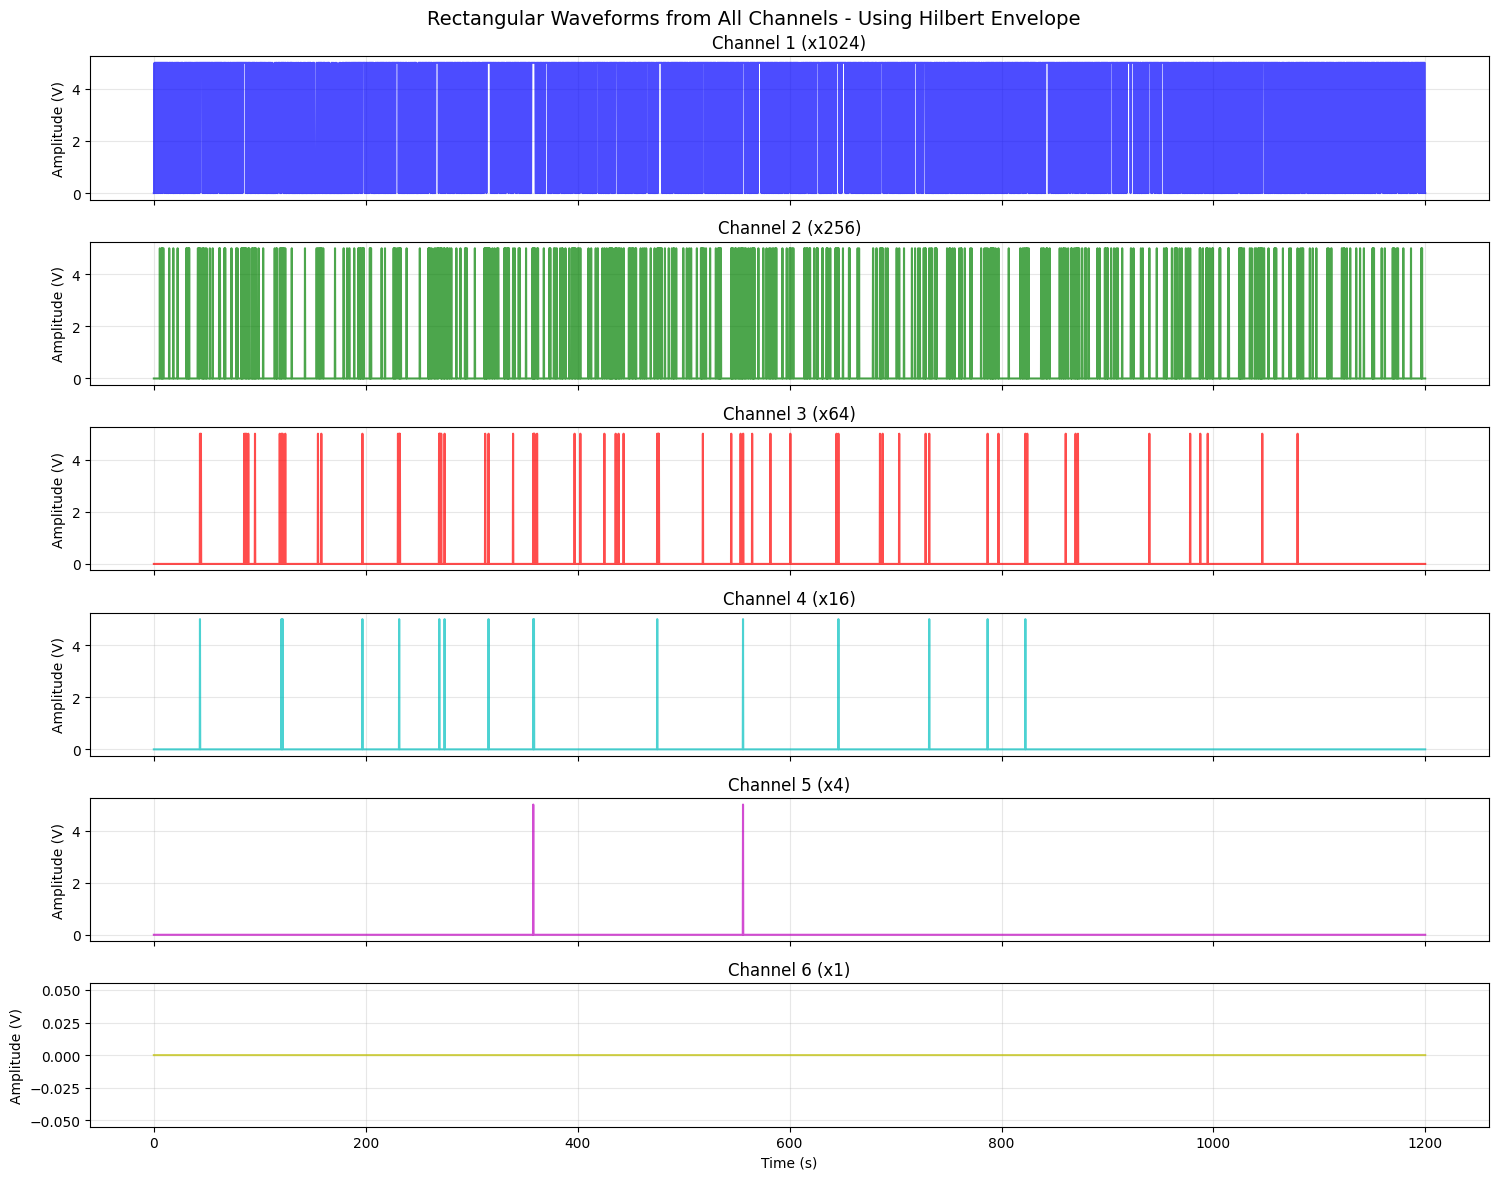

In [28]:
# visualize rect waveforms from hilbert envelope (takes a while to run ~2 mins)
fig, axes = plt.subplots(6, 1, figsize=(15, 12), sharex=True)

# channel data and colors
channels = ['ch1', 'ch2', 'ch3', 'ch4', 'ch5', 'ch6']
colors = ['b', 'g', 'r', 'c', 'm', 'y']
gains = [1024, 256, 64, 16, 4, 1]
downsample_factor = 10000  

for i, (ch, color, gain) in enumerate(zip(channels, colors, gains)):
    # downsample data for plotting to reduce memory usage
    downsampled_time = rect_hilbert['time'][::downsample_factor]
    downsampled_signal = rect_hilbert[ch][::downsample_factor]

    axes[i].plot(downsampled_time, downsampled_signal, color=color, alpha=0.7)
    axes[i].set_ylabel("Amplitude (V)")
    axes[i].set_title(f"Channel {i+1} (x{gain})")
    axes[i].grid(True, alpha=0.3)
    # axes[i].set_ylim(0, 5.5)

# only set xlabel for bottom subplot
axes[-1].set_xlabel("Time (s)")

# zoom in on a specific time range
# for ax in axes:
#     ax.set_xlim(41.2, 42)

plt.suptitle("Rectangular Waveforms from All Channels - Using Hilbert Envelope", fontsize=14)
plt.tight_layout()
plt.savefig("calibration_plots/test/test_rect_from_hilbert_subplots.png", dpi=300, bbox_inches='tight')
plt.show()

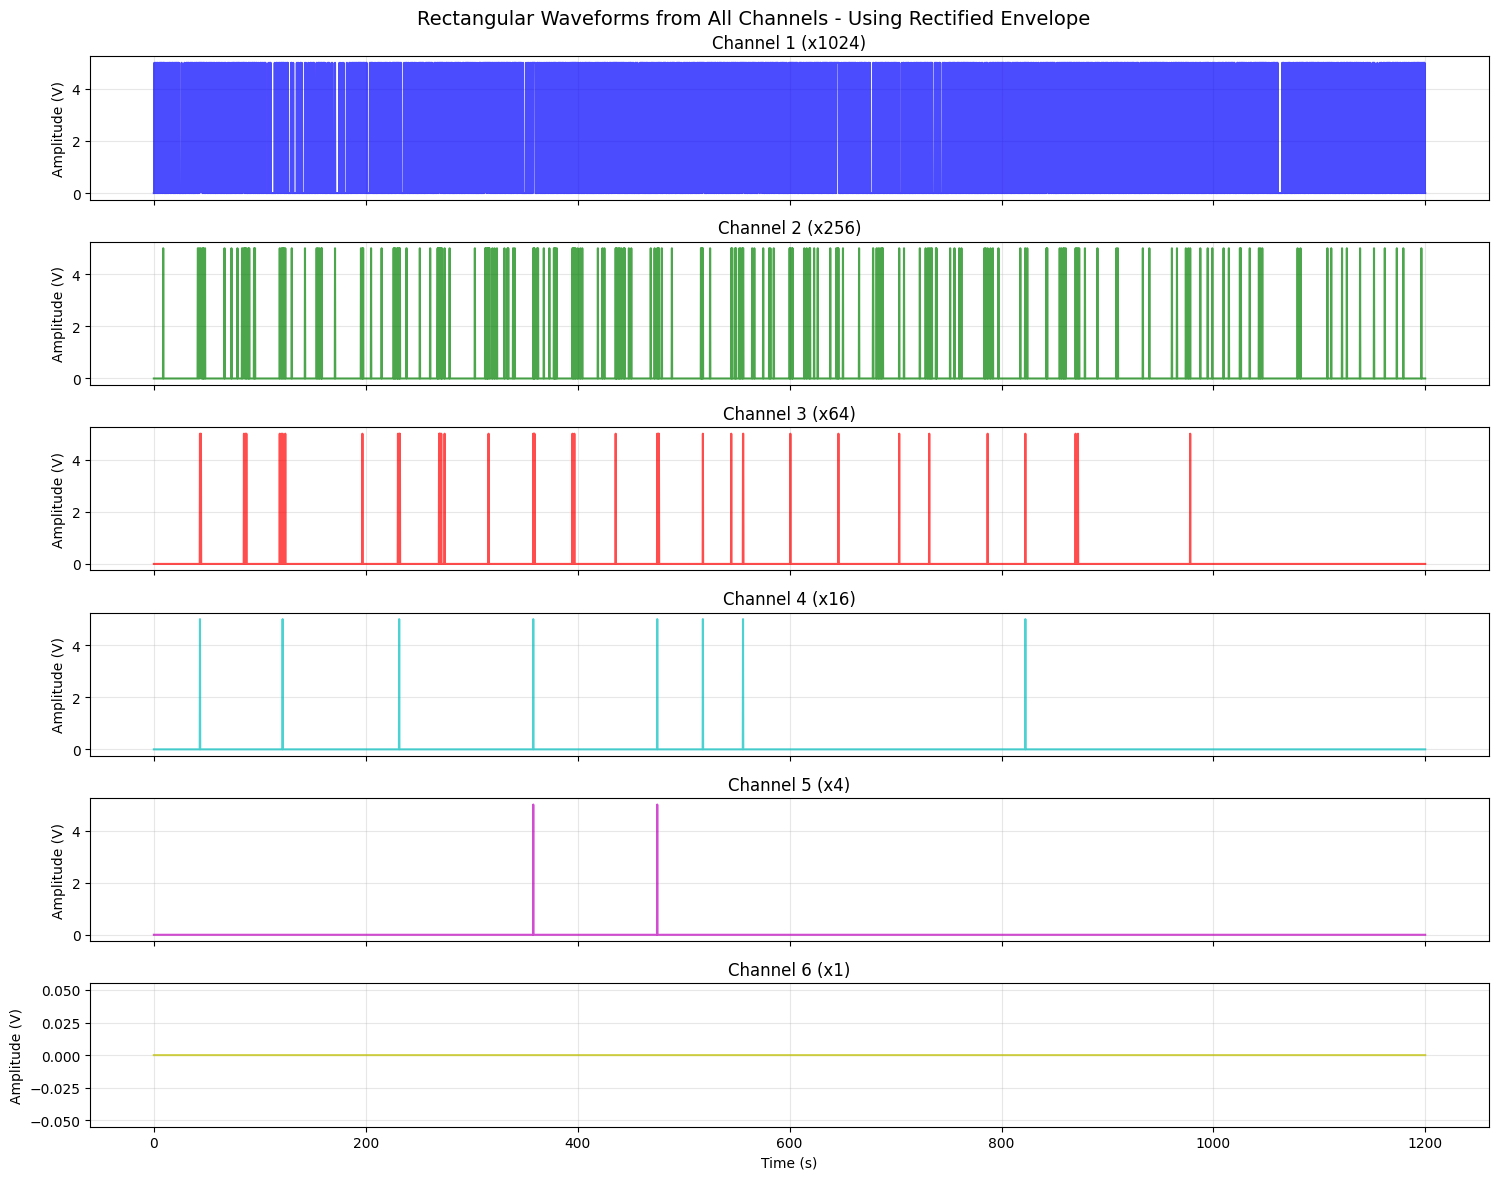

In [29]:
# visualize rect waveforms from rectified envelope (takes a while to run ~2 mins)
fig, axes = plt.subplots(6, 1, figsize=(15, 12), sharex=True)

# channel data and colors
channels = ['ch1', 'ch2', 'ch3', 'ch4', 'ch5', 'ch6']
colors = ['b', 'g', 'r', 'c', 'm', 'y']
gains = [1024, 256, 64, 16, 4, 1]
downsample_factor = 10000 

for i, (ch, color, gain) in enumerate(zip(channels, colors, gains)):
    # downsample data for plotting to reduce memory usage
    downsampled_time = rect_rectified['time'][::downsample_factor]
    downsampled_signal = rect_rectified[ch][::downsample_factor]

    axes[i].plot(downsampled_time, downsampled_signal, color=color, alpha=0.7)
    axes[i].set_ylabel("Amplitude (V)")
    axes[i].set_title(f"Channel {i+1} (x{gain})")
    axes[i].grid(True, alpha=0.3)
    # axes[i].set_ylim(0, 5.5)

# only set xlabel for bottom subplot
axes[-1].set_xlabel("Time (s)")

# zoom in on a specific time range
# for ax in axes:
#     ax.set_xlim(41.2, 42)

plt.suptitle("Rectangular Waveforms from All Channels - Using Rectified Envelope", fontsize=14)
plt.tight_layout()
plt.savefig("calibration_plots/test/test_rect_from_rectified_subplots.png", dpi=300, bbox_inches='tight')
plt.show()

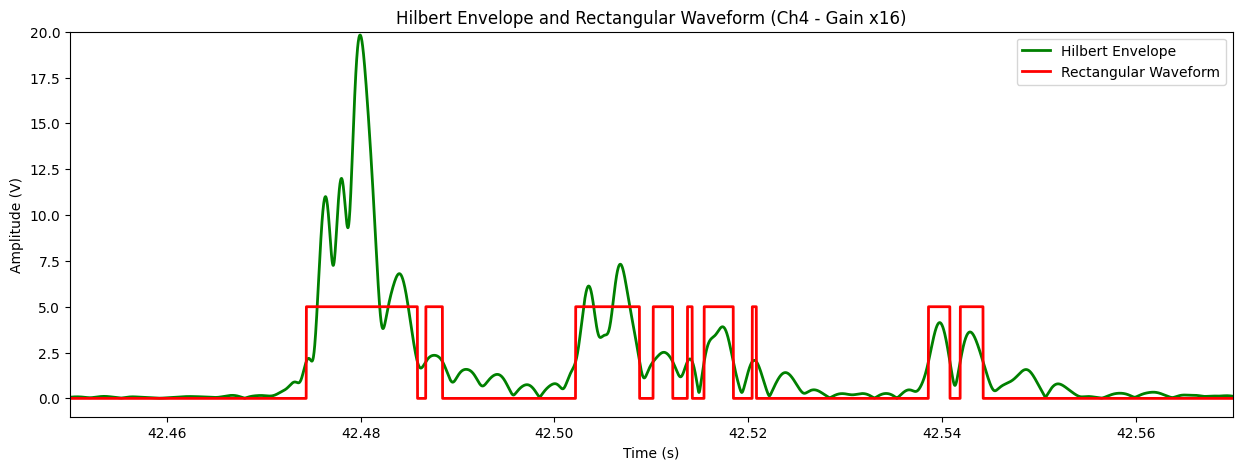

In [30]:
# visualize the envelopes
plt.figure(figsize=(15, 5))
plt.plot(time, envelope_hilbert*16, 'g-', linewidth=2, label='Hilbert Envelope')
plt.plot(time, rect_hilbert['ch4'], 'r-', linewidth=2, label='Rectangular Waveform')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (V)")
plt.title("Hilbert Envelope and Rectangular Waveform (Ch4 - Gain x16)")
plt.legend(loc='upper right')
plt.xlim(42.45, 42.57)
plt.ylim(-1, 20)
#plt.savefig("calibration_plots/test/test_signal_envelopes_full.png", dpi=300)
plt.show()

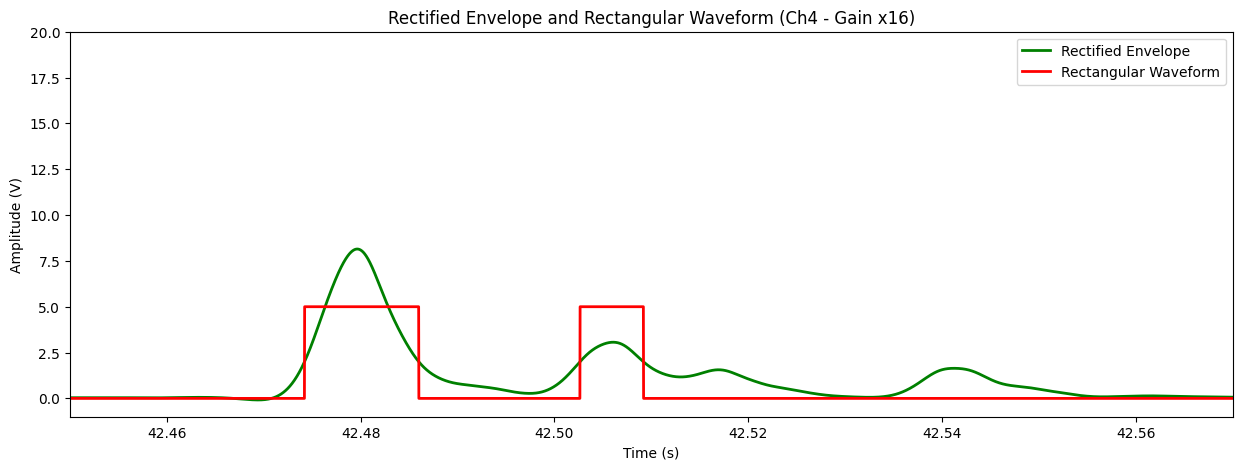

In [31]:
# visualize the envelopes
plt.figure(figsize=(15, 5))
plt.plot(time, envelope_rectified*16, 'g-', linewidth=2, label='Rectified Envelope')
plt.plot(time, rect_rectified['ch4'], 'r-', linewidth=2, label='Rectangular Waveform')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (V)")
plt.title("Rectified Envelope and Rectangular Waveform (Ch4 - Gain x16)")
plt.legend(loc='upper right')
plt.xlim(42.45, 42.57)
plt.ylim(-1, 20)
#plt.savefig("calibration_plots/test/test_signal_envelopes_full.png", dpi=300)
plt.show()

Counting pulses by particle impact 

In [32]:
gains = {
    6: 1,
    5: 4,
    4: 16,
    3: 64,
    2: 256,
    1: 1024
}

fs = samplerate  # sampling frequency (Hz)
dt = 1.0         # target bin size in seconds

# build bins
time_bins = np.arange(time[0], time[-1] + dt, dt)
time_index = pd.to_timedelta(time_bins[:-1], unit="s")

# function to count impulses (rising edges) per second
def count_impulses(rect_signal, fs):
    # detect rising edges: 0→5 transitions
    rising_edges = np.diff((rect_signal > 0).astype(int)) == 1
    edge_times = time[1:][rising_edges]
    # bin counts into 1s intervals
    counts, _ = np.histogram(edge_times, bins=time_bins)
    return counts

# prepare output containers
results_hilbert = pd.DataFrame(index=time_index)
results_rectified = pd.DataFrame(index=time_index)

# 1) count impulses
for ch, gain in gains.items():
    impulses = count_impulses(rect_hilbert[f"ch{ch}"].values, fs)
    results_hilbert[f"impulses_ch{ch}"] = impulses

    impulses = count_impulses(rect_rectified[f"ch{ch}"].values, fs)
    results_rectified[f"impulses_ch{ch}"] = impulses

# 2) average envelope amplitude at 1 Hz
# put both hilbert + rectified envelopes into one structure
df_env = pd.DataFrame({
    "time": time,
    "hilbert": envelope_hilbert,
    "rectified": envelope_rectified
})

# resample to 1 Hz (average every second)
df_env.index = pd.to_timedelta(df_env["time"], unit="s")
df_env_1hz = df_env.resample("1s").mean()

# final result: combine counts + averages
final_hilbert = results_hilbert.join(df_env_1hz["hilbert"])
final_rectified = results_rectified.join(df_env_1hz["rectified"])

### Separate impacts by particle ID 

In [37]:

samples = pd.read_csv('ManualRockMovements-1/mov1_pipe_particles.csv')  

For Hilbert Envelope

In [39]:
# sample info file 
samples = pd.read_csv('ManualRockMovements-1/mov1_pipe_particles.csv')  

results = []

for _, row in samples.iterrows():
    sid = row["id"]
    t0 = row["start_time"]
    t1 = row["end_time"]
    # slice the dataframe by timedelta index
    window = final_hilbert.loc[pd.to_timedelta(t0, unit="s") : pd.to_timedelta(t1, unit="s")]

    # sum impulses per channel
    impulse_sums = window.filter(like="impulses_ch").sum()

    # amplitude stats from hilbert column
    max_amp = window["hilbert"].max()
    mean_amp = window["hilbert"].mean()
    median_amp = window["hilbert"].median()

    # collect everything
    result = {"SampleID": sid, "t0": t0, "t1": t1,
              "max_amp": max_amp, "mean_amp": mean_amp, "median_amp": median_amp}
    # add channel impulse counts
    result.update(impulse_sums.to_dict())

    results.append(result)

# Final results dataframe
df_results = pd.DataFrame(results)
df_results.to_csv("ManualRockMovements-1/impact_results_hilbert.csv", index=False)
print(df_results.head())


   SampleID   t0   t1   max_amp  mean_amp  median_amp  impulses_ch6  \
0       167   41   48  0.104819  0.033154    0.022914             6   
1         6   80   90  0.051422  0.014335    0.007297             2   
2         8  115  125  0.161945  0.032526    0.007799            10   
3       168  150  160  0.089417  0.021061    0.009669             4   
4       150  194  199  0.046850  0.019737    0.011301             2   

   impulses_ch5  impulses_ch4  impulses_ch3  impulses_ch2  impulses_ch1  
0            16            96           264           604           978  
1             8            65           195           628          1690  
2            31            89           230           509          1493  
3            16           110           255           489          1351  
4            16            41           139           414           882  


For Rectified Envelope

In [40]:
results = []

for _, row in samples.iterrows():
    sid = row["id"]
    t0 = row["start_time"]
    t1 = row["end_time"]
    # slice the dataframe by timedelta index
    window = final_rectified.loc[pd.to_timedelta(t0, unit="s") : pd.to_timedelta(t1, unit="s")]

    # sum impulses per channel
    impulse_sums = window.filter(like="impulses_ch").sum()

    # amplitude stats from rectified column
    max_amp = window["rectified"].max()
    mean_amp = window["rectified"].mean()
    median_amp = window["rectified"].median()

    # collect everything
    result = {"SampleID": sid, "t0": t0, "t1": t1,
              "max_amp": max_amp, "mean_amp": mean_amp, "median_amp": median_amp}
    # add channel impulse counts
    result.update(impulse_sums.to_dict())

    results.append(result)

# Final results dataframe
df_results_rectified = pd.DataFrame(results)
df_results_rectified.to_csv("ManualRockMovements-1/impact_results_rectified.csv", index=False)
print(df_results_rectified.head())

   SampleID   t0   t1   max_amp  mean_amp  median_amp  impulses_ch6  \
0       167   41   48  0.066690  0.021102    0.014590             2   
1         6   80   90  0.032721  0.009123    0.004644             0   
2         8  115  125  0.102959  0.020696    0.004962             2   
3       168  150  160  0.056917  0.013404    0.006157             1   
4       150  194  199  0.029839  0.012567    0.007194             0   

   impulses_ch5  impulses_ch4  impulses_ch3  impulses_ch2  impulses_ch1  
0             7            21            48            94           175  
1             3            12            39            92           290  
2             9            27            51            88           226  
3             4            25            57            80           190  
4             3            16            30            67           159  


## MRM 2 - Impact Pipe

In [ ]:
filepath = 'ManualRockMovements-2/audio/Nicole_091823-000100.flac'

# load stereo signal
signal, sr = librosa.load(filepath, sr=None, mono=False)
left_channel = signal[0]
right_channel = signal[1]

#create the time axis
duration = signal.shape[-1] / sr
time = np.linspace(0, duration, signal.shape[-1])

# plot the signals
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# plot the right channel (top)
axes[0].plot(time, signal[1], label='Right Channel', color='b', alpha=0.7)
axes[0].set_title("Right Channel")
axes[0].set_ylabel("Amplitude")
axes[0].legend()

# plot the left channel (bottom)
axes[1].plot(time, signal[0], label='Left Channel', color='r', alpha=0.7)
axes[1].set_title("Left Channel")
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("Amplitude")
axes[1].legend()

# adjust layout to prevent overlap
plt.tight_layout()
plt.show()


Left channel is impact pipe also, since these experiments were on the same day MRM1

#### Compute and plotting envelope

In [ ]:
# === USER INPUT ===
left_gain_db = 23   # left channel gain (dB)
right_gain_db = 4 # right channel gain (dB)
use_channel = "left"  # which one was the impact pipe

# convert dB gain to linear - linear amplitude ratio
left_gain = 10 ** (left_gain_db / 20)
right_gain = 10 ** (right_gain_db / 20)

# choose channel and correct for gain
y = signal[0] if use_channel == "left" else signal[1]
gain_correction = left_gain if use_channel == "left" else right_gain
y = y / gain_correction  # undo preamp gain

# compute envelope
analytic_signal = scipy.signal.hilbert(y)
envelope = np.abs(analytic_signal)

# estimate dynamic threshold (adjust multiplier as needed)
noise_level = np.median(envelope)
threshold = 40 * noise_level

# detect packet start/end points
above_thresh = envelope > threshold # boolean array indicating where the envelope is above the threshold
packet_starts = np.where(np.diff(above_thresh.astype(int)) == 1)[0] # where the envelope crosses above the threshold
packet_ends = np.where(np.diff(above_thresh.astype(int)) == -1)[0] # where the envelope crosses below the threshold

# remove any packets that are too short (less than 0.1 seconds)
if packet_ends[0] < packet_starts[0]: 
    packet_ends = packet_ends[1:] 
if len(packet_starts) > len(packet_ends):
    packet_starts = packet_starts[:-1]

# extract max amplitudes per packet
max_amplitudes = [np.max(np.abs(y[start:end])) for start, end in zip(packet_starts, packet_ends)]

Plotting envelope and packets

In [ ]:
start_time = 0  # in seconds
end_time = 400  # in seconds

# convert times to sample indices
start_idx = int(start_time * sr)
end_idx = int(end_time * sr)

# slice all relevant arrays to just this window
y_zoom = y[start_idx:end_idx]
envelope_zoom = envelope[start_idx:end_idx]
time_zoom = np.arange(start_idx, end_idx) / sr

# Plot (zoomed-in view) 
plt.figure(figsize=(15, 5))
plt.plot(time_zoom, y_zoom, color='black', linewidth=0.6, label="raw signal")
plt.plot(time_zoom, envelope_zoom, color='darkred', linewidth=1.0, label="envelope")
plt.axhline(threshold, color='black', linestyle='--', linewidth=1, label="threshold")

# only show shaded packets that fall within the zoomed-in range
for start, end in zip(packet_starts, packet_ends):
    if start >= start_idx and end <= end_idx:
        plt.axvspan(start / sr, end / sr, color='lightcoral', alpha=0.4)

# clean up legend
handles, labels = plt.gca().get_legend_handles_labels()
labels = ["Δtₚ" if "Patch" in str(h) else l for h, l in zip(handles, labels)]
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.xlabel("time (s)")
plt.ylabel("amplitude")
plt.title(f"Zoomed Packet Detection — {start_time}s to {end_time}s — Channel: {use_channel}")
plt.grid(True)
plt.tight_layout()

# calculate the max amplitude of envelope in this window
max_amplitude_zoom = np.max(np.abs(envelope_zoom))
print(f"Max amplitude in the zoomed-in window: {max_amplitude_zoom:.2f}")

plt.show()


In [ ]:
# how many packets were detected?
print(f"Detected {len(packet_starts)} packets in {len(y)/sr:.2f} seconds of audio.")

Plotting and saving group impacts

In [ ]:
# import csv
csv_path = 'ManualRockMovements-2/mov2_pipe_particles.csv'
times_df = pd.read_csv(csv_path)

# Make sure "plots" folder exists
os.makedirs('ManualRockMovements-2/plots', exist_ok=True)

# Iterate through each row of the dataframe
for idx, row in times_df.iterrows():
    id_num = row['id']
    start_time = row['start_time']
    end_time = row['end_time']
    
    # Convert times to sample indices
    start_idx = int(start_time * sr)
    end_idx = int(end_time * sr)

    # Slice the arrays
    y_zoom = y[start_idx:end_idx]
    envelope_zoom = envelope[start_idx:end_idx]
    time_zoom = np.arange(start_idx, end_idx) / sr

    # Create the plot
    plt.figure(figsize=(15, 5))
    plt.plot(time_zoom, y_zoom, color='black', linewidth=0.6, label="raw signal")
    plt.plot(time_zoom, envelope_zoom, color='darkred', linewidth=1.0, label="envelope")
    plt.axhline(threshold, color='black', linestyle='--', linewidth=1, label="threshold")

    # Shade packets only if within the zoomed window
    for start, end in zip(packet_starts, packet_ends):
        if start >= start_idx and end <= end_idx:
            plt.axvspan(start / sr, end / sr, color='lightcoral', alpha=0.4)

    # Clean up legend
    handles, labels = plt.gca().get_legend_handles_labels()
    labels = ["Δtₚ" if "Patch" in str(h) else l for h, l in zip(handles, labels)]
    by_label = OrderedDict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

    plt.xlabel("time (s)")
    plt.ylabel("amplitude")
    plt.title(f"Zoomed Packet Detection — Group ID: {id_num} — {start_time}s to {end_time}s — Channel: {use_channel}")
    plt.grid(True)
    plt.tight_layout()

    # Save the figure
    plot_filename = f"ManualRockMovements-2/plots/pipe_groupsignal_{id_num}.png"
    plt.savefig(plot_filename, dpi=300)
    plt.close()

    print(f"Saved plot for group {id_num} to {plot_filename}")

Displaying the max amplitude for each particle ID

In [ ]:
# import csv
csv_path = 'ManualRockMovements-2/mov2_pipe_particles.csv'
times_df = pd.read_csv(csv_path)

# loop through each row of the DataFrame
for idx, row in times_df.iterrows():
    id_num = row['id']
    start_time = row['start_time']
    end_time = row['end_time']

    # convert to sample indices
    start_idx = int(start_time * sr)
    end_idx = int(end_time * sr)

    # slice the raw signal
    y_zoom = y[start_idx:end_idx]

    # get max amplitude
    max_amp = np.max(np.abs(y_zoom))

    print(f"Group ID {id_num}: Max Raw amplitude = {max_amp:.4f}")


In [ ]:
# loop through each row of the DataFrame
for idx, row in times_df.iterrows():
    id_num = row['id']
    start_time = row['start_time']
    end_time = row['end_time']

    # convert to sample indices
    start_idx = int(start_time * sr)
    end_idx = int(end_time * sr)

    # slice the envelope
    envelope_zoom = envelope[start_idx:end_idx]

    # get max amplitude
    max_amp = np.max(np.abs(envelope_zoom))

    print(f"Group ID {id_num}: Max Envelope amplitude = {max_amp:.4f}")

## MRM 2 - Hydrophone

In [ ]:
# === USER INPUT ===
left_gain_db = 23   # left channel gain (dB)
right_gain_db = 4 # right channel gain (dB)
use_channel = "right"  # which one was the hydrophone

# convert dB gain to linear - linear amplitude ratio
left_gain = 10 ** (left_gain_db / 20)
right_gain = 10 ** (right_gain_db / 20)

# choose channel and correct for gain
y = signal[0] if use_channel == "left" else signal[1]
gain_correction = left_gain if use_channel == "left" else right_gain
y = y / gain_correction  # undo preamp gain

# compute envelope
analytic_signal = scipy.signal.hilbert(y)
envelope = np.abs(analytic_signal)

# estimate dynamic threshold (adjust multiplier as needed)
noise_level = np.median(envelope)
threshold = 40 * noise_level

# detect packet start/end points
above_thresh = envelope > threshold # boolean array indicating where the envelope is above the threshold
packet_starts = np.where(np.diff(above_thresh.astype(int)) == 1)[0] # where the envelope crosses above the threshold
packet_ends = np.where(np.diff(above_thresh.astype(int)) == -1)[0] # where the envelope crosses below the threshold

# remove any packets that are too short (less than 0.1 seconds)
if packet_ends[0] < packet_starts[0]: 
    packet_ends = packet_ends[1:] 
if len(packet_starts) > len(packet_ends):
    packet_starts = packet_starts[:-1]

# extract max amplitudes per packet
max_amplitudes = [np.max(np.abs(y[start:end])) for start, end in zip(packet_starts, packet_ends)]

Plotting envelope and packets

In [ ]:
start_time = 0  # in seconds
end_time = 400  # in seconds

# convert times to sample indices
start_idx = int(start_time * sr)
end_idx = int(end_time * sr)

# slice all relevant arrays to just this window
y_zoom = y[start_idx:end_idx]
envelope_zoom = envelope[start_idx:end_idx]
time_zoom = np.arange(start_idx, end_idx) / sr

# Plot (zoomed-in view) 
plt.figure(figsize=(15, 5))
plt.plot(time_zoom, y_zoom, color='black', linewidth=0.6, label="raw signal")
plt.plot(time_zoom, envelope_zoom, color='darkred', linewidth=1.0, label="envelope")
plt.axhline(threshold, color='black', linestyle='--', linewidth=1, label="threshold")

# only show shaded packets that fall within the zoomed-in range
for start, end in zip(packet_starts, packet_ends):
    if start >= start_idx and end <= end_idx:
        plt.axvspan(start / sr, end / sr, color='lightcoral', alpha=0.4)

# clean up legend
handles, labels = plt.gca().get_legend_handles_labels()
labels = ["Δtₚ" if "Patch" in str(h) else l for h, l in zip(handles, labels)]
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.xlabel("time (s)")
plt.ylabel("amplitude")
plt.title(f"Zoomed Packet Detection — {start_time}s to {end_time}s — Channel: {use_channel}")
plt.grid(True)
plt.tight_layout()

# calculate the max amplitude of envelope in this window
max_amplitude_zoom = np.max(np.abs(envelope_zoom))
print(f"Max amplitude in the zoomed-in window: {max_amplitude_zoom:.2f}")

plt.show()

Plotting and saving groups

In [ ]:
# import csv
csv_path = 'ManualRockMovements-2/mov2_mic_particles.csv'
times_df = pd.read_csv(csv_path)

# Make sure "plots" folder exists
os.makedirs('ManualRockMovements-2/plots/hydrophones', exist_ok=True)

# Iterate through each row of the dataframe
for idx, row in times_df.iterrows():
    id_num = row['id']
    start_time = row['start_time']
    end_time = row['end_time']
    
    # Convert times to sample indices
    start_idx = int(start_time * sr)
    end_idx = int(end_time * sr)

    # Slice the arrays
    y_zoom = y[start_idx:end_idx]
    envelope_zoom = envelope[start_idx:end_idx]
    time_zoom = np.arange(start_idx, end_idx) / sr

    # Create the plot
    plt.figure(figsize=(15, 5))
    plt.plot(time_zoom, y_zoom, color='black', linewidth=0.6, label="raw signal")
    plt.plot(time_zoom, envelope_zoom, color='darkred', linewidth=1.0, label="envelope")
    plt.axhline(threshold, color='black', linestyle='--', linewidth=1, label="threshold")

    # Shade packets only if within the zoomed window
    for start, end in zip(packet_starts, packet_ends):
        if start >= start_idx and end <= end_idx:
            plt.axvspan(start / sr, end / sr, color='lightcoral', alpha=0.4)

    # Clean up legend
    handles, labels = plt.gca().get_legend_handles_labels()
    labels = ["Δtₚ" if "Patch" in str(h) else l for h, l in zip(handles, labels)]
    by_label = OrderedDict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

    plt.xlabel("time (s)")
    plt.ylabel("amplitude")
    plt.title(f"Zoomed Packet Detection — Group ID: {id_num} — {start_time}s to {end_time}s — Channel: {use_channel}")
    plt.grid(True)
    plt.tight_layout()

    # Save the figure
    plot_filename = f"ManualRockMovements-2/plots/hydrophones/mic_groupsignal_{id_num}.png"
    plt.savefig(plot_filename, dpi=300)
    plt.close()

Displaying the max amplitude for each particle ID

In [ ]:
csv_path = 'ManualRockMovements-2/mov2_mic_particles.csv'
times_df = pd.read_csv(csv_path)

for idx, row in times_df.iterrows():
    id_num = row['id']
    start_time = row['start_time']
    end_time = row['end_time']

    # convert to sample indices
    start_idx = int(start_time * sr)
    end_idx = int(end_time * sr)

    # slice the raw signal
    y_zoom = y[start_idx:end_idx]

    # get max amplitude
    max_amp = np.max(np.abs(y_zoom))

    print(f"Group ID {id_num}: Max Raw amplitude = {max_amp:.4f}")  

In [ ]:
for idx, row in times_df.iterrows():
    id_num = row['id']
    start_time = row['start_time']
    end_time = row['end_time']

    # convert to sample indices
    start_idx = int(start_time * sr)
    end_idx = int(end_time * sr)

    # slice the envelope signal
    envelope_zoom = envelope[start_idx:end_idx]

    # get max amplitude from the envelope
    max_amp = np.max(np.abs(envelope_zoom))

    print(f"Particle ID {id_num}: Max Envelope amplitude = {max_amp:.4f}")


# Flood Experiments

### Flood 1

In [ ]:
filepath = 'EXP-09-20-23-FLOW1/audio/Nicole_091823-000100.flac'

# load stereo signal
signal, sr = librosa.load(filepath, sr=None, mono=False)
left_channel = signal[0]
right_channel = signal[1]

#create the time axis
duration = signal.shape[-1] / sr
time = np.linspace(0, duration, signal.shape[-1])

# plot the signals
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# plot the right channel (top)
axes[0].plot(time, signal[1], label='Right Channel', color='b', alpha=0.7)
axes[0].set_title("Right Channel")
axes[0].set_ylabel("Amplitude")
axes[0].legend()

# plot the left channel (bottom)
axes[1].plot(time, signal[0], label='Left Channel', color='r', alpha=0.7)
axes[1].set_title("Left Channel")
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("Amplitude")
axes[1].legend()

# adjust layout to prevent overlap
plt.tight_layout()
plt.show()

pipe recording: unusable
- For some reason there was a lot of static in the recordings, don't know if it was like a hardware thing? 
- Still gonna try to see if it gives me anything

In [ ]:
# === USER INPUT ===
left_gain_db = 23   # left channel gain (dB)
right_gain_db = 4 # right channel gain (dB)
use_channel = "left"  # which one was the impact pipe

# convert dB gain to linear - linear amplitude ratio
left_gain = 10 ** (left_gain_db / 20)
right_gain = 10 ** (right_gain_db / 20)

# choose channel and correct for gain
y = signal[0] if use_channel == "left" else signal[1]
gain_correction = left_gain if use_channel == "left" else right_gain
y = y / gain_correction  # undo preamp gain

# compute envelope
analytic_signal = scipy.signal.hilbert(y)
envelope = np.abs(analytic_signal)

# estimate dynamic threshold (adjust multiplier as needed)
noise_level = np.median(envelope)
threshold = 40 * noise_level

# detect packet start/end points
above_thresh = envelope > threshold # boolean array indicating where the envelope is above the threshold
packet_starts = np.where(np.diff(above_thresh.astype(int)) == 1)[0] # where the envelope crosses above the threshold
packet_ends = np.where(np.diff(above_thresh.astype(int)) == -1)[0] # where the envelope crosses below the threshold

# remove any packets that are too short (less than 0.1 seconds)
if packet_ends[0] < packet_starts[0]: 
    packet_ends = packet_ends[1:] 
if len(packet_starts) > len(packet_ends):
    packet_starts = packet_starts[:-1]

# extract max amplitudes per packet
max_amplitudes = [np.max(np.abs(y[start:end])) for start, end in zip(packet_starts, packet_ends)]

In [ ]:
start_time = 180  # in seconds
end_time = 660  # in seconds

# convert times to sample indices
start_idx = int(start_time * sr)
end_idx = int(end_time * sr)

# slice all relevant arrays to just this window
y_zoom = y[start_idx:end_idx]
envelope_zoom = envelope[start_idx:end_idx]
time_zoom = np.arange(start_idx, end_idx) / sr

# Plot (zoomed-in view) 
plt.figure(figsize=(15, 5))
plt.plot(time_zoom, y_zoom, color='black', linewidth=0.6, label="raw signal")
plt.plot(time_zoom, envelope_zoom, color='darkred', linewidth=1.0, label="envelope")
plt.axhline(threshold, color='black', linestyle='--', linewidth=1, label="threshold")

# only show shaded packets that fall within the zoomed-in range
for start, end in zip(packet_starts, packet_ends):
    if start >= start_idx and end <= end_idx:
        plt.axvspan(start / sr, end / sr, color='lightcoral', alpha=0.4)

# clean up legend
handles, labels = plt.gca().get_legend_handles_labels()
labels = ["Δtₚ" if "Patch" in str(h) else l for h, l in zip(handles, labels)]
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.xlabel("time (s)")
plt.ylabel("amplitude")
plt.title(f"Flood 2 — {start_time}s to {end_time}s — Channel: {use_channel}")
plt.grid(True)
plt.tight_layout()

# calculate the max amplitude of envelope in this window
max_envelope_zoom = np.max(np.abs(envelope_zoom))
print(f"Max envelope amplitude in the zoomed-in window: {max_envelope_zoom:.4f}")
max_signal_zoom = np.max(np.abs(y_zoom))
print(f"Max raw signal amplitude in the zoomed-in window: {max_signal_zoom:.4f}")

plt.show()  

microphone

In [ ]:
# === USER INPUT ===
left_gain_db = 23   # left channel gain (dB)
right_gain_db = 4 # right channel gain (dB)
use_channel = "right"  # which one was the impact pipe

# convert dB gain to linear - linear amplitude ratio
left_gain = 10 ** (left_gain_db / 20)
right_gain = 10 ** (right_gain_db / 20)

# choose channel and correct for gain
y = signal[0] if use_channel == "left" else signal[1]
gain_correction = left_gain if use_channel == "left" else right_gain
y = y / gain_correction  # undo preamp gain

# compute envelope
analytic_signal = scipy.signal.hilbert(y)
envelope = np.abs(analytic_signal)

# estimate dynamic threshold (adjust multiplier as needed)
noise_level = np.median(envelope)
threshold = 40 * noise_level

# detect packet start/end points
above_thresh = envelope > threshold # boolean array indicating where the envelope is above the threshold
packet_starts = np.where(np.diff(above_thresh.astype(int)) == 1)[0] # where the envelope crosses above the threshold
packet_ends = np.where(np.diff(above_thresh.astype(int)) == -1)[0] # where the envelope crosses below the threshold

# remove any packets that are too short (less than 0.1 seconds)
if packet_ends[0] < packet_starts[0]: 
    packet_ends = packet_ends[1:] 
if len(packet_starts) > len(packet_ends):
    packet_starts = packet_starts[:-1]

# extract max amplitudes per packet
max_amplitudes = [np.max(np.abs(y[start:end])) for start, end in zip(packet_starts, packet_ends)]

In [ ]:
start_time = 180  # in seconds
end_time = 660  # in seconds

# convert times to sample indices
start_idx = int(start_time * sr)
end_idx = int(end_time * sr)

# slice all relevant arrays to just this window
y_zoom = y[start_idx:end_idx]
envelope_zoom = envelope[start_idx:end_idx]
time_zoom = np.arange(start_idx, end_idx) / sr

# Plot (zoomed-in view) 
plt.figure(figsize=(15, 5))
plt.plot(time_zoom, y_zoom, color='black', linewidth=0.6, label="raw signal")
plt.plot(time_zoom, envelope_zoom, color='darkred', linewidth=1.0, label="envelope")
plt.axhline(threshold, color='black', linestyle='--', linewidth=1, label="threshold")

# only show shaded packets that fall within the zoomed-in range
for start, end in zip(packet_starts, packet_ends):
    if start >= start_idx and end <= end_idx:
        plt.axvspan(start / sr, end / sr, color='lightcoral', alpha=0.4)

# clean up legend
handles, labels = plt.gca().get_legend_handles_labels()
labels = ["Δtₚ" if "Patch" in str(h) else l for h, l in zip(handles, labels)]
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.xlabel("time (s)")
plt.ylabel("amplitude")
plt.title(f"Flood 2 — {start_time}s to {end_time}s — Channel: {use_channel}")
plt.grid(True)
plt.tight_layout()

# calculate the max amplitude of envelope in this window
max_envelope_zoom = np.max(np.abs(envelope_zoom))
print(f"Max envelope amplitude in the zoomed-in window: {max_envelope_zoom:.4f}")
max_signal_zoom = np.max(np.abs(y_zoom))
print(f"Max raw signal amplitude in the zoomed-in window: {max_signal_zoom:.4f}")

plt.show()  

### Flood 2

In [ ]:
filepath = 'EXP-09-20-23-FLOW2/audio/Nicole_091823-000100.flac'

# load stereo signal
signal, sr = librosa.load(filepath, sr=None, mono=False)
left_channel = signal[0]
right_channel = signal[1]

#create the time axis
duration = signal.shape[-1] / sr
time = np.linspace(0, duration, signal.shape[-1])

# plot the signals
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# plot the right channel (top)
axes[0].plot(time, signal[1], label='Right Channel', color='b', alpha=0.7)
axes[0].set_title("Right Channel")
axes[0].set_ylabel("Amplitude")
axes[0].legend()

# plot the left channel (bottom)
axes[1].plot(time, signal[0], label='Left Channel', color='r', alpha=0.7)
axes[1].set_title("Left Channel")
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("Amplitude")
axes[1].legend()

# adjust layout to prevent overlap
plt.tight_layout()
plt.show()

pipe

In [ ]:
# === USER INPUT ===
left_gain_db = 23   # left channel gain (dB)
right_gain_db = 4 # right channel gain (dB)
use_channel = "left"  # which one was the impact pipe

# convert dB gain to linear - linear amplitude ratio
left_gain = 10 ** (left_gain_db / 20)
right_gain = 10 ** (right_gain_db / 20)

# choose channel and correct for gain
y = signal[0] if use_channel == "left" else signal[1]
gain_correction = left_gain if use_channel == "left" else right_gain
y = y / gain_correction  # undo preamp gain

# compute envelope
analytic_signal = scipy.signal.hilbert(y)
envelope = np.abs(analytic_signal)

# estimate dynamic threshold (adjust multiplier as needed)
noise_level = np.median(envelope)
threshold = 40 * noise_level

# detect packet start/end points
above_thresh = envelope > threshold # boolean array indicating where the envelope is above the threshold
packet_starts = np.where(np.diff(above_thresh.astype(int)) == 1)[0] # where the envelope crosses above the threshold
packet_ends = np.where(np.diff(above_thresh.astype(int)) == -1)[0] # where the envelope crosses below the threshold

# remove any packets that are too short (less than 0.1 seconds)
if packet_ends[0] < packet_starts[0]: 
    packet_ends = packet_ends[1:] 
if len(packet_starts) > len(packet_ends):
    packet_starts = packet_starts[:-1]

# extract max amplitudes per packet
max_amplitudes = [np.max(np.abs(y[start:end])) for start, end in zip(packet_starts, packet_ends)]

In [ ]:
start_time = 200  # in seconds
end_time = 250  # in seconds

# convert times to sample indices
start_idx = int(start_time * sr)
end_idx = int(end_time * sr)

# slice all relevant arrays to just this window
y_zoom = y[start_idx:end_idx]
envelope_zoom = envelope[start_idx:end_idx]
time_zoom = np.arange(start_idx, end_idx) / sr

# Plot (zoomed-in view) 
plt.figure(figsize=(15, 5))
plt.plot(time_zoom, y_zoom, color='black', linewidth=0.6, label="raw signal")
plt.plot(time_zoom, envelope_zoom, color='darkred', linewidth=1.0, label="envelope")
plt.axhline(threshold, color='black', linestyle='--', linewidth=1, label="threshold")

# only show shaded packets that fall within the zoomed-in range
for start, end in zip(packet_starts, packet_ends):
    if start >= start_idx and end <= end_idx:
        plt.axvspan(start / sr, end / sr, color='lightcoral', alpha=0.4)

# clean up legend
handles, labels = plt.gca().get_legend_handles_labels()
labels = ["Δtₚ" if "Patch" in str(h) else l for h, l in zip(handles, labels)]
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.xlabel("time (s)")
plt.ylabel("amplitude")
plt.title(f"Flood 2 — {start_time}s to {end_time}s — Channel: {use_channel}")
plt.grid(True)
plt.tight_layout()

# calculate the max amplitude of envelope in this window
max_envelope_zoom = np.max(np.abs(envelope_zoom))
print(f"Max envelope amplitude in the zoomed-in window: {max_envelope_zoom:.4f}")
max_signal_zoom = np.max(np.abs(y_zoom))
print(f"Max raw signal amplitude in the zoomed-in window: {max_signal_zoom:.4f}")

plt.show()


microphone

In [ ]:
# === USER INPUT ===
left_gain_db = 23   # left channel gain (dB)
right_gain_db = 4 # right channel gain (dB)
use_channel = "right"  # which one was the impact pipe

# convert dB gain to linear - linear amplitude ratio
left_gain = 10 ** (left_gain_db / 20)
right_gain = 10 ** (right_gain_db / 20)

# choose channel and correct for gain
y = signal[0] if use_channel == "left" else signal[1]
gain_correction = left_gain if use_channel == "left" else right_gain
y = y / gain_correction  # undo preamp gain

# compute envelope
analytic_signal = scipy.signal.hilbert(y)
envelope = np.abs(analytic_signal)

# estimate dynamic threshold (adjust multiplier as needed)
noise_level = np.median(envelope)
threshold = 40 * noise_level

# detect packet start/end points
above_thresh = envelope > threshold # boolean array indicating where the envelope is above the threshold
packet_starts = np.where(np.diff(above_thresh.astype(int)) == 1)[0] # where the envelope crosses above the threshold
packet_ends = np.where(np.diff(above_thresh.astype(int)) == -1)[0] # where the envelope crosses below the threshold

# remove any packets that are too short (less than 0.1 seconds)
if packet_ends[0] < packet_starts[0]: 
    packet_ends = packet_ends[1:] 
if len(packet_starts) > len(packet_ends):
    packet_starts = packet_starts[:-1]

# extract max amplitudes per packet
max_amplitudes = [np.max(np.abs(y[start:end])) for start, end in zip(packet_starts, packet_ends)]

In [ ]:
start_time = 200  # in seconds
end_time = 250  # in seconds

# convert times to sample indices
start_idx = int(start_time * sr)
end_idx = int(end_time * sr)

# slice all relevant arrays to just this window
y_zoom = y[start_idx:end_idx]
envelope_zoom = envelope[start_idx:end_idx]
time_zoom = np.arange(start_idx, end_idx) / sr

# Plot (zoomed-in view) 
plt.figure(figsize=(15, 5))
plt.plot(time_zoom, y_zoom, color='black', linewidth=0.6, label="raw signal")
plt.plot(time_zoom, envelope_zoom, color='darkred', linewidth=1.0, label="envelope")
plt.axhline(threshold, color='black', linestyle='--', linewidth=1, label="threshold")

# only show shaded packets that fall within the zoomed-in range
for start, end in zip(packet_starts, packet_ends):
    if start >= start_idx and end <= end_idx:
        plt.axvspan(start / sr, end / sr, color='lightcoral', alpha=0.4)

# clean up legend
handles, labels = plt.gca().get_legend_handles_labels()
labels = ["Δtₚ" if "Patch" in str(h) else l for h, l in zip(handles, labels)]
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.xlabel("time (s)")
plt.ylabel("amplitude")
plt.title(f"Flood 2 — {start_time}s to {end_time}s — Channel: {use_channel}")
plt.grid(True)
plt.tight_layout()

# calculate the max amplitude of envelope in this window
max_envelope_zoom = np.max(np.abs(envelope_zoom))
print(f"Max envelope amplitude in the zoomed-in window: {max_envelope_zoom:.4f}")
max_signal_zoom = np.max(np.abs(y_zoom))
print(f"Max raw signal amplitude in the zoomed-in window: {max_signal_zoom:.4f}")

plt.show()


### Flood 3

In [ ]:
filepath = 'EXP-09-20-23-FLOW3/audio/Nicole_091823-000100.flac'

# load stereo signal
signal, sr = librosa.load(filepath, sr=None, mono=False)
left_channel = signal[0]
right_channel = signal[1]

#create the time axis
duration = signal.shape[-1] / sr
time = np.linspace(0, duration, signal.shape[-1])

# plot the signals
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# plot the right channel (top)
axes[0].plot(time, signal[1], label='Right Channel', color='b', alpha=0.7)
axes[0].set_title("Right Channel")
axes[0].set_ylabel("Amplitude")
axes[0].legend()

# plot the left channel (bottom)
axes[1].plot(time, signal[0], label='Left Channel', color='r', alpha=0.7)
axes[1].set_title("Left Channel")
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("Amplitude")
axes[1].legend()

# adjust layout to prevent overlap
plt.tight_layout()
plt.show()

pipe

In [ ]:
# === USER INPUT ===
left_gain_db = 23   # left channel gain (dB)
right_gain_db = 4 # right channel gain (dB)
use_channel = "left"  # which one was the impact pipe

# convert dB gain to linear - linear amplitude ratio
left_gain = 10 ** (left_gain_db / 20)
right_gain = 10 ** (right_gain_db / 20)

# choose channel and correct for gain
y = signal[0] if use_channel == "left" else signal[1]
gain_correction = left_gain if use_channel == "left" else right_gain
y = y / gain_correction  # undo preamp gain

# compute envelope
analytic_signal = scipy.signal.hilbert(y)
envelope = np.abs(analytic_signal)

# estimate dynamic threshold (adjust multiplier as needed)
noise_level = np.median(envelope)
threshold = 40 * noise_level

# detect packet start/end points
above_thresh = envelope > threshold # boolean array indicating where the envelope is above the threshold
packet_starts = np.where(np.diff(above_thresh.astype(int)) == 1)[0] # where the envelope crosses above the threshold
packet_ends = np.where(np.diff(above_thresh.astype(int)) == -1)[0] # where the envelope crosses below the threshold

# remove any packets that are too short (less than 0.1 seconds)
if packet_ends[0] < packet_starts[0]: 
    packet_ends = packet_ends[1:] 
if len(packet_starts) > len(packet_ends):
    packet_starts = packet_starts[:-1]

# extract max amplitudes per packet
max_amplitudes = [np.max(np.abs(y[start:end])) for start, end in zip(packet_starts, packet_ends)]

In [ ]:
start_time = 250  # in seconds
end_time = 350  # in seconds

# convert times to sample indices
start_idx = int(start_time * sr)
end_idx = int(end_time * sr)

# slice all relevant arrays to just this window
y_zoom = y[start_idx:end_idx]
envelope_zoom = envelope[start_idx:end_idx]
time_zoom = np.arange(start_idx, end_idx) / sr

# Plot (zoomed-in view) 
plt.figure(figsize=(15, 5))
plt.plot(time_zoom, y_zoom, color='black', linewidth=0.6, label="raw signal")
plt.plot(time_zoom, envelope_zoom, color='darkred', linewidth=1.0, label="envelope")
plt.axhline(threshold, color='black', linestyle='--', linewidth=1, label="threshold")

# only show shaded packets that fall within the zoomed-in range
for start, end in zip(packet_starts, packet_ends):
    if start >= start_idx and end <= end_idx:
        plt.axvspan(start / sr, end / sr, color='lightcoral', alpha=0.4)

# clean up legend
handles, labels = plt.gca().get_legend_handles_labels()
labels = ["Δtₚ" if "Patch" in str(h) else l for h, l in zip(handles, labels)]
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.xlabel("time (s)")
plt.ylabel("amplitude")
plt.title(f"Flood 3 — {start_time}s to {end_time}s — Channel: {use_channel}")
plt.grid(True)
plt.tight_layout()

# calculate the max amplitude of envelope in this window
max_envelope_zoom = np.max(np.abs(envelope_zoom))
print(f"Max envelope amplitude in the zoomed-in window: {max_envelope_zoom:.4f}")
max_signal_zoom = np.max(np.abs(y_zoom))
print(f"Max raw signal amplitude in the zoomed-in window: {max_signal_zoom:.4f}")

plt.show()

microphone

In [ ]:
# === USER INPUT ===
left_gain_db = 23   # left channel gain (dB)
right_gain_db = 4 # right channel gain (dB)
use_channel = "right"  # which one was the impact pipe

# convert dB gain to linear - linear amplitude ratio
left_gain = 10 ** (left_gain_db / 20)
right_gain = 10 ** (right_gain_db / 20)

# choose channel and correct for gain
y = signal[0] if use_channel == "left" else signal[1]
gain_correction = left_gain if use_channel == "left" else right_gain
y = y / gain_correction  # undo preamp gain

# compute envelope
analytic_signal = scipy.signal.hilbert(y)
envelope = np.abs(analytic_signal)

# estimate dynamic threshold (adjust multiplier as needed)
noise_level = np.median(envelope)
threshold = 40 * noise_level

# detect packet start/end points
above_thresh = envelope > threshold # boolean array indicating where the envelope is above the threshold
packet_starts = np.where(np.diff(above_thresh.astype(int)) == 1)[0] # where the envelope crosses above the threshold
packet_ends = np.where(np.diff(above_thresh.astype(int)) == -1)[0] # where the envelope crosses below the threshold

# remove any packets that are too short (less than 0.1 seconds)
if packet_ends[0] < packet_starts[0]: 
    packet_ends = packet_ends[1:] 
if len(packet_starts) > len(packet_ends):
    packet_starts = packet_starts[:-1]

# extract max amplitudes per packet
max_amplitudes = [np.max(np.abs(y[start:end])) for start, end in zip(packet_starts, packet_ends)]

In [ ]:
start_time = 250  # in seconds
end_time = 350  # in seconds

# convert times to sample indices
start_idx = int(start_time * sr)
end_idx = int(end_time * sr)

# slice all relevant arrays to just this window
y_zoom = y[start_idx:end_idx]
envelope_zoom = envelope[start_idx:end_idx]
time_zoom = np.arange(start_idx, end_idx) / sr

# Plot (zoomed-in view) 
plt.figure(figsize=(15, 5))
plt.plot(time_zoom, y_zoom, color='black', linewidth=0.6, label="raw signal")
plt.plot(time_zoom, envelope_zoom, color='darkred', linewidth=1.0, label="envelope")
plt.axhline(threshold, color='black', linestyle='--', linewidth=1, label="threshold")

# only show shaded packets that fall within the zoomed-in range
for start, end in zip(packet_starts, packet_ends):
    if start >= start_idx and end <= end_idx:
        plt.axvspan(start / sr, end / sr, color='lightcoral', alpha=0.4)

# clean up legend
handles, labels = plt.gca().get_legend_handles_labels()
labels = ["Δtₚ" if "Patch" in str(h) else l for h, l in zip(handles, labels)]
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.xlabel("time (s)")
plt.ylabel("amplitude")
plt.title(f"Flood 3 — {start_time}s to {end_time}s — Channel: {use_channel}")
plt.grid(True)
plt.tight_layout()

# calculate the max amplitude of envelope in this window
max_envelope_zoom = np.max(np.abs(envelope_zoom))
print(f"Max envelope amplitude in the zoomed-in window: {max_envelope_zoom:.4f}")
max_signal_zoom = np.max(np.abs(y_zoom))
print(f"Max raw signal amplitude in the zoomed-in window: {max_signal_zoom:.4f}")

plt.show()

### Flood 4

In [ ]:
filepath = 'EXP-09-21-23-FLOW4/audio/Nicole_091823-000100.flac'

# load stereo signal
signal, sr = librosa.load(filepath, sr=None, mono=False)
left_channel = signal[0]
right_channel = signal[1]

#create the time axis
duration = signal.shape[-1] / sr
time = np.linspace(0, duration, signal.shape[-1])

# plot the signals
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# plot the right channel (top)
axes[0].plot(time, signal[1], label='Right Channel', color='b', alpha=0.7)
axes[0].set_title("Right Channel")
axes[0].set_ylabel("Amplitude")
axes[0].legend()

# plot the left channel (bottom)
axes[1].plot(time, signal[0], label='Left Channel', color='r', alpha=0.7)
axes[1].set_title("Left Channel")
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("Amplitude")
axes[1].legend()

# adjust layout to prevent overlap
plt.tight_layout()
plt.show()

pipe: no impact 
- Still going to try to get a max amplitude

In [ ]:
# === USER INPUT ===
left_gain_db = 23   # left channel gain (dB)
right_gain_db = 4 # right channel gain (dB)
use_channel = "left"  # which one was the impact pipe

# convert dB gain to linear - linear amplitude ratio
left_gain = 10 ** (left_gain_db / 20)
right_gain = 10 ** (right_gain_db / 20)

# choose channel and correct for gain
y = signal[0] if use_channel == "left" else signal[1]
gain_correction = left_gain if use_channel == "left" else right_gain
y = y / gain_correction  # undo preamp gain

# compute envelope
analytic_signal = scipy.signal.hilbert(y)
envelope = np.abs(analytic_signal)

# estimate dynamic threshold (adjust multiplier as needed)
noise_level = np.median(envelope)
threshold = 40 * noise_level

# detect packet start/end points
above_thresh = envelope > threshold # boolean array indicating where the envelope is above the threshold
packet_starts = np.where(np.diff(above_thresh.astype(int)) == 1)[0] # where the envelope crosses above the threshold
packet_ends = np.where(np.diff(above_thresh.astype(int)) == -1)[0] # where the envelope crosses below the threshold

# remove any packets that are too short (less than 0.1 seconds)
if packet_ends[0] < packet_starts[0]: 
    packet_ends = packet_ends[1:] 
if len(packet_starts) > len(packet_ends):
    packet_starts = packet_starts[:-1]

# extract max amplitudes per packet
max_amplitudes = [np.max(np.abs(y[start:end])) for start, end in zip(packet_starts, packet_ends)]

In [ ]:
start_time = 600  # in seconds
end_time = 800  # in seconds

# convert times to sample indices
start_idx = int(start_time * sr)
end_idx = int(end_time * sr)

# slice all relevant arrays to just this window
y_zoom = y[start_idx:end_idx]
envelope_zoom = envelope[start_idx:end_idx]
time_zoom = np.arange(start_idx, end_idx) / sr

# Plot (zoomed-in view) 
plt.figure(figsize=(15, 5))
plt.plot(time_zoom, y_zoom, color='black', linewidth=0.6, label="raw signal")
plt.plot(time_zoom, envelope_zoom, color='darkred', linewidth=1.0, label="envelope")
plt.axhline(threshold, color='black', linestyle='--', linewidth=1, label="threshold")

# only show shaded packets that fall within the zoomed-in range
for start, end in zip(packet_starts, packet_ends):
    if start >= start_idx and end <= end_idx:
        plt.axvspan(start / sr, end / sr, color='lightcoral', alpha=0.4)

# clean up legend
handles, labels = plt.gca().get_legend_handles_labels()
labels = ["Δtₚ" if "Patch" in str(h) else l for h, l in zip(handles, labels)]
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.xlabel("time (s)")
plt.ylabel("amplitude")
plt.title(f"Flood 4 — {start_time}s to {end_time}s — Channel: {use_channel}")
plt.grid(True)
plt.tight_layout()

# calculate the max amplitude of envelope in this window
max_envelope_zoom = np.max(np.abs(envelope_zoom))
print(f"Max envelope amplitude in the zoomed-in window: {max_envelope_zoom:.4f}")
max_signal_zoom = np.max(np.abs(y_zoom))
print(f"Max raw signal amplitude in the zoomed-in window: {max_signal_zoom:.4f}")

plt.show()

microphone

In [ ]:
# === USER INPUT ===
left_gain_db = 23   # left channel gain (dB)
right_gain_db = 4 # right channel gain (dB)
use_channel = "right"  # which one was the impact pipe

# convert dB gain to linear - linear amplitude ratio
left_gain = 10 ** (left_gain_db / 20)
right_gain = 10 ** (right_gain_db / 20)

# choose channel and correct for gain
y = signal[0] if use_channel == "left" else signal[1]
gain_correction = left_gain if use_channel == "left" else right_gain
y = y / gain_correction  # undo preamp gain

# compute envelope
analytic_signal = scipy.signal.hilbert(y)
envelope = np.abs(analytic_signal)

# estimate dynamic threshold (adjust multiplier as needed)
noise_level = np.median(envelope)
threshold = 40 * noise_level

# detect packet start/end points
above_thresh = envelope > threshold # boolean array indicating where the envelope is above the threshold
packet_starts = np.where(np.diff(above_thresh.astype(int)) == 1)[0] # where the envelope crosses above the threshold
packet_ends = np.where(np.diff(above_thresh.astype(int)) == -1)[0] # where the envelope crosses below the threshold

# remove any packets that are too short (less than 0.1 seconds)
if packet_ends[0] < packet_starts[0]: 
    packet_ends = packet_ends[1:] 
if len(packet_starts) > len(packet_ends):
    packet_starts = packet_starts[:-1]

# extract max amplitudes per packet
max_amplitudes = [np.max(np.abs(y[start:end])) for start, end in zip(packet_starts, packet_ends)]

In [ ]:
start_time = 600  # in seconds
end_time = 800  # in seconds

# convert times to sample indices
start_idx = int(start_time * sr)
end_idx = int(end_time * sr)

# slice all relevant arrays to just this window
y_zoom = y[start_idx:end_idx]
envelope_zoom = envelope[start_idx:end_idx]
time_zoom = np.arange(start_idx, end_idx) / sr

# Plot (zoomed-in view) 
plt.figure(figsize=(15, 5))
plt.plot(time_zoom, y_zoom, color='black', linewidth=0.6, label="raw signal")
plt.plot(time_zoom, envelope_zoom, color='darkred', linewidth=1.0, label="envelope")
plt.axhline(threshold, color='black', linestyle='--', linewidth=1, label="threshold")

# only show shaded packets that fall within the zoomed-in range
for start, end in zip(packet_starts, packet_ends):
    if start >= start_idx and end <= end_idx:
        plt.axvspan(start / sr, end / sr, color='lightcoral', alpha=0.4)

# clean up legend
handles, labels = plt.gca().get_legend_handles_labels()
labels = ["Δtₚ" if "Patch" in str(h) else l for h, l in zip(handles, labels)]
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.xlabel("time (s)")
plt.ylabel("amplitude")
plt.title(f"Flood 4 — {start_time}s to {end_time}s — Channel: {use_channel}")
plt.grid(True)
plt.tight_layout()

# calculate the max amplitude of envelope in this window
max_envelope_zoom = np.max(np.abs(envelope_zoom))
print(f"Max envelope amplitude in the zoomed-in window: {max_envelope_zoom:.4f}")
max_signal_zoom = np.max(np.abs(y_zoom))
print(f"Max raw signal amplitude in the zoomed-in window: {max_signal_zoom:.4f}")

plt.show()

### Flood 5

In [ ]:
filepath = 'EXP-09-21-23-FLOW5/audio/Nicole_091823-000100.flac'

# load stereo signal
signal, sr = librosa.load(filepath, sr=None, mono=False)
left_channel = signal[0]
right_channel = signal[1]

#create the time axis
duration = signal.shape[-1] / sr
time = np.linspace(0, duration, signal.shape[-1])

# plot the signals
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# plot the right channel (top)
axes[0].plot(time, signal[1], label='Right Channel', color='b', alpha=0.7)
axes[0].set_title("Right Channel")
axes[0].set_ylabel("Amplitude")
axes[0].legend()

# plot the left channel (bottom)
axes[1].plot(time, signal[0], label='Left Channel', color='r', alpha=0.7)
axes[1].set_title("Left Channel")
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("Amplitude")
axes[1].legend()

# adjust layout to prevent overlap
plt.tight_layout()
plt.show()

pipe

In [ ]:
# === USER INPUT ===
left_gain_db = 23   # left channel gain (dB)
right_gain_db = 4 # right channel gain (dB)
use_channel = "left"  # which one was the impact pipe

# convert dB gain to linear - linear amplitude ratio
left_gain = 10 ** (left_gain_db / 20)
right_gain = 10 ** (right_gain_db / 20)

# choose channel and correct for gain
y = signal[0] if use_channel == "left" else signal[1]
gain_correction = left_gain if use_channel == "left" else right_gain
y = y / gain_correction  # undo preamp gain

# compute envelope
analytic_signal = scipy.signal.hilbert(y)
envelope = np.abs(analytic_signal)

# estimate dynamic threshold (adjust multiplier as needed)
noise_level = np.median(envelope)
threshold = 40 * noise_level

# detect packet start/end points
above_thresh = envelope > threshold # boolean array indicating where the envelope is above the threshold
packet_starts = np.where(np.diff(above_thresh.astype(int)) == 1)[0] # where the envelope crosses above the threshold
packet_ends = np.where(np.diff(above_thresh.astype(int)) == -1)[0] # where the envelope crosses below the threshold

# remove any packets that are too short (less than 0.1 seconds)
if packet_ends[0] < packet_starts[0]: 
    packet_ends = packet_ends[1:] 
if len(packet_starts) > len(packet_ends):
    packet_starts = packet_starts[:-1]

# extract max amplitudes per packet
max_amplitudes = [np.max(np.abs(y[start:end])) for start, end in zip(packet_starts, packet_ends)]

In [ ]:
start_time = 50  # in seconds
end_time = 200  # in seconds

# convert times to sample indices
start_idx = int(start_time * sr)
end_idx = int(end_time * sr)

# slice all relevant arrays to just this window
y_zoom = y[start_idx:end_idx]
envelope_zoom = envelope[start_idx:end_idx]
time_zoom = np.arange(start_idx, end_idx) / sr

# Plot (zoomed-in view) 
plt.figure(figsize=(15, 5))
plt.plot(time_zoom, y_zoom, color='black', linewidth=0.6, label="raw signal")
plt.plot(time_zoom, envelope_zoom, color='darkred', linewidth=1.0, label="envelope")
plt.axhline(threshold, color='black', linestyle='--', linewidth=1, label="threshold")

# only show shaded packets that fall within the zoomed-in range
for start, end in zip(packet_starts, packet_ends):
    if start >= start_idx and end <= end_idx:
        plt.axvspan(start / sr, end / sr, color='lightcoral', alpha=0.4)

# clean up legend
handles, labels = plt.gca().get_legend_handles_labels()
labels = ["Δtₚ" if "Patch" in str(h) else l for h, l in zip(handles, labels)]
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.xlabel("time (s)")
plt.ylabel("amplitude")
plt.title(f"Flood 5 — {start_time}s to {end_time}s — Channel: {use_channel}")
plt.grid(True)
plt.tight_layout()

# calculate the max amplitude of envelope in this window
max_envelope_zoom = np.max(np.abs(envelope_zoom))
print(f"Max envelope amplitude in the zoomed-in window: {max_envelope_zoom:.4f}")
max_signal_zoom = np.max(np.abs(y_zoom))
print(f"Max raw signal amplitude in the zoomed-in window: {max_signal_zoom:.4f}")

plt.show()

microphone

In [ ]:
# === USER INPUT ===
left_gain_db = 23   # left channel gain (dB)
right_gain_db = 4 # right channel gain (dB)
use_channel = "right"  # which one was the impact pipe

# convert dB gain to linear - linear amplitude ratio
left_gain = 10 ** (left_gain_db / 20)
right_gain = 10 ** (right_gain_db / 20)

# choose channel and correct for gain
y = signal[0] if use_channel == "left" else signal[1]
gain_correction = left_gain if use_channel == "left" else right_gain
y = y / gain_correction  # undo preamp gain

# compute envelope
analytic_signal = scipy.signal.hilbert(y)
envelope = np.abs(analytic_signal)

# estimate dynamic threshold (adjust multiplier as needed)
noise_level = np.median(envelope)
threshold = 40 * noise_level

# detect packet start/end points
above_thresh = envelope > threshold # boolean array indicating where the envelope is above the threshold
packet_starts = np.where(np.diff(above_thresh.astype(int)) == 1)[0] # where the envelope crosses above the threshold
packet_ends = np.where(np.diff(above_thresh.astype(int)) == -1)[0] # where the envelope crosses below the threshold

# remove any packets that are too short (less than 0.1 seconds)
if packet_ends[0] < packet_starts[0]: 
    packet_ends = packet_ends[1:] 
if len(packet_starts) > len(packet_ends):
    packet_starts = packet_starts[:-1]

# extract max amplitudes per packet
max_amplitudes = [np.max(np.abs(y[start:end])) for start, end in zip(packet_starts, packet_ends)]

In [ ]:
start_time = 50  # in seconds
end_time = 200  # in seconds

# convert times to sample indices
start_idx = int(start_time * sr)
end_idx = int(end_time * sr)

# slice all relevant arrays to just this window
y_zoom = y[start_idx:end_idx]
envelope_zoom = envelope[start_idx:end_idx]
time_zoom = np.arange(start_idx, end_idx) / sr

# Plot (zoomed-in view) 
plt.figure(figsize=(15, 5))
plt.plot(time_zoom, y_zoom, color='black', linewidth=0.6, label="raw signal")
plt.plot(time_zoom, envelope_zoom, color='darkred', linewidth=1.0, label="envelope")
plt.axhline(threshold, color='black', linestyle='--', linewidth=1, label="threshold")

# only show shaded packets that fall within the zoomed-in range
for start, end in zip(packet_starts, packet_ends):
    if start >= start_idx and end <= end_idx:
        plt.axvspan(start / sr, end / sr, color='lightcoral', alpha=0.4)

# clean up legend
handles, labels = plt.gca().get_legend_handles_labels()
labels = ["Δtₚ" if "Patch" in str(h) else l for h, l in zip(handles, labels)]
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.xlabel("time (s)")
plt.ylabel("amplitude")
plt.title(f"Flood 5 — {start_time}s to {end_time}s — Channel: {use_channel}")
plt.grid(True)
plt.tight_layout()

# calculate the max amplitude of envelope in this window
max_envelope_zoom = np.max(np.abs(envelope_zoom))
print(f"Max envelope amplitude in the zoomed-in window: {max_envelope_zoom:.4f}")
max_signal_zoom = np.max(np.abs(y_zoom))
print(f"Max raw signal amplitude in the zoomed-in window: {max_signal_zoom:.4f}")

plt.show()

### Flood 6

In [ ]:
filepath = 'EXP-09-22-23-FLOW6/audio/Nicole_091823-000100.flac'

# load stereo signal
signal, sr = librosa.load(filepath, sr=None, mono=False)
left_channel = signal[0]
right_channel = signal[1]

#create the time axis
duration = signal.shape[-1] / sr
time = np.linspace(0, duration, signal.shape[-1])

# plot the signals
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# plot the right channel (top)
axes[0].plot(time, signal[1], label='Right Channel', color='b', alpha=0.7)
axes[0].set_title("Right Channel")
axes[0].set_ylabel("Amplitude")
axes[0].legend()

# plot the left channel (bottom)
axes[1].plot(time, signal[0], label='Left Channel', color='r', alpha=0.7)
axes[1].set_title("Left Channel")
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("Amplitude")
axes[1].legend()

# adjust layout to prevent overlap
plt.tight_layout()
plt.show()

pipe

In [ ]:
# === USER INPUT ===
left_gain_db = 30   # left channel gain (dB)
right_gain_db = 2 # right channel gain (dB)
use_channel = "left"  # which one was the impact pipe

# convert dB gain to linear - linear amplitude ratio
left_gain = 10 ** (left_gain_db / 20)
right_gain = 10 ** (right_gain_db / 20)

# choose channel and correct for gain
y = signal[0] if use_channel == "left" else signal[1]
gain_correction = left_gain if use_channel == "left" else right_gain
y = y / gain_correction  # undo preamp gain

# compute envelope
analytic_signal = scipy.signal.hilbert(y)
envelope = np.abs(analytic_signal)

# estimate dynamic threshold (adjust multiplier as needed)
noise_level = np.median(envelope)
threshold = 40 * noise_level

# detect packet start/end points
above_thresh = envelope > threshold # boolean array indicating where the envelope is above the threshold
packet_starts = np.where(np.diff(above_thresh.astype(int)) == 1)[0] # where the envelope crosses above the threshold
packet_ends = np.where(np.diff(above_thresh.astype(int)) == -1)[0] # where the envelope crosses below the threshold

# remove any packets that are too short (less than 0.1 seconds)
if packet_ends[0] < packet_starts[0]: 
    packet_ends = packet_ends[1:] 
if len(packet_starts) > len(packet_ends):
    packet_starts = packet_starts[:-1]

# extract max amplitudes per packet
max_amplitudes = [np.max(np.abs(y[start:end])) for start, end in zip(packet_starts, packet_ends)]

In [ ]:
start_time = 200  # in seconds
end_time = 400  # in seconds

# convert times to sample indices
start_idx = int(start_time * sr)
end_idx = int(end_time * sr)

# slice all relevant arrays to just this window
y_zoom = y[start_idx:end_idx]
envelope_zoom = envelope[start_idx:end_idx]
time_zoom = np.arange(start_idx, end_idx) / sr

# Plot (zoomed-in view) 
plt.figure(figsize=(15, 5))
plt.plot(time_zoom, y_zoom, color='black', linewidth=0.6, label="raw signal")
plt.plot(time_zoom, envelope_zoom, color='darkred', linewidth=1.0, label="envelope")
plt.axhline(threshold, color='black', linestyle='--', linewidth=1, label="threshold")

# only show shaded packets that fall within the zoomed-in range
for start, end in zip(packet_starts, packet_ends):
    if start >= start_idx and end <= end_idx:
        plt.axvspan(start / sr, end / sr, color='lightcoral', alpha=0.4)

# clean up legend
handles, labels = plt.gca().get_legend_handles_labels()
labels = ["Δtₚ" if "Patch" in str(h) else l for h, l in zip(handles, labels)]
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.xlabel("time (s)")
plt.ylabel("amplitude")
plt.title(f"Flood 6 — {start_time}s to {end_time}s — Channel: {use_channel}")
plt.grid(True)
plt.tight_layout()

# calculate the max amplitude of envelope in this window
max_envelope_zoom = np.max(np.abs(envelope_zoom))
print(f"Max envelope amplitude in the zoomed-in window: {max_envelope_zoom:.4f}")
max_signal_zoom = np.max(np.abs(y_zoom))
print(f"Max raw signal amplitude in the zoomed-in window: {max_signal_zoom:.4f}")

plt.show()

microphone

In [ ]:
# === USER INPUT ===
left_gain_db = 30   # left channel gain (dB)
right_gain_db = 2 # right channel gain (dB)
use_channel = "right"  # which one was the impact pipe

# convert dB gain to linear - linear amplitude ratio
left_gain = 10 ** (left_gain_db / 20)
right_gain = 10 ** (right_gain_db / 20)

# choose channel and correct for gain
y = signal[0] if use_channel == "left" else signal[1]
gain_correction = left_gain if use_channel == "left" else right_gain
y = y / gain_correction  # undo preamp gain

# compute envelope
analytic_signal = scipy.signal.hilbert(y)
envelope = np.abs(analytic_signal)

# estimate dynamic threshold (adjust multiplier as needed)
noise_level = np.median(envelope)
threshold = 40 * noise_level

# detect packet start/end points
above_thresh = envelope > threshold # boolean array indicating where the envelope is above the threshold
packet_starts = np.where(np.diff(above_thresh.astype(int)) == 1)[0] # where the envelope crosses above the threshold
packet_ends = np.where(np.diff(above_thresh.astype(int)) == -1)[0] # where the envelope crosses below the threshold

# remove any packets that are too short (less than 0.1 seconds)
if packet_ends[0] < packet_starts[0]: 
    packet_ends = packet_ends[1:] 
if len(packet_starts) > len(packet_ends):
    packet_starts = packet_starts[:-1]

# extract max amplitudes per packet
max_amplitudes = [np.max(np.abs(y[start:end])) for start, end in zip(packet_starts, packet_ends)]

In [ ]:
start_time = 200  # in seconds
end_time = 400  # in seconds

# convert times to sample indices
start_idx = int(start_time * sr)
end_idx = int(end_time * sr)

# slice all relevant arrays to just this window
y_zoom = y[start_idx:end_idx]
envelope_zoom = envelope[start_idx:end_idx]
time_zoom = np.arange(start_idx, end_idx) / sr

# Plot (zoomed-in view) 
plt.figure(figsize=(15, 5))
plt.plot(time_zoom, y_zoom, color='black', linewidth=0.6, label="raw signal")
plt.plot(time_zoom, envelope_zoom, color='darkred', linewidth=1.0, label="envelope")
plt.axhline(threshold, color='black', linestyle='--', linewidth=1, label="threshold")

# only show shaded packets that fall within the zoomed-in range
for start, end in zip(packet_starts, packet_ends):
    if start >= start_idx and end <= end_idx:
        plt.axvspan(start / sr, end / sr, color='lightcoral', alpha=0.4)

# clean up legend
handles, labels = plt.gca().get_legend_handles_labels()
labels = ["Δtₚ" if "Patch" in str(h) else l for h, l in zip(handles, labels)]
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.xlabel("time (s)")
plt.ylabel("amplitude")
plt.title(f"Flood 6 — {start_time}s to {end_time}s — Channel: {use_channel}")
plt.grid(True)
plt.tight_layout()

# calculate the max amplitude of envelope in this window
max_envelope_zoom = np.max(np.abs(envelope_zoom))
print(f"Max envelope amplitude in the zoomed-in window: {max_envelope_zoom:.4f}")
max_signal_zoom = np.max(np.abs(y_zoom))
print(f"Max raw signal amplitude in the zoomed-in window: {max_signal_zoom:.4f}")

plt.show()

### Flood 7
These is no recording for this flood :(

### Flood 8

In [ ]:
filepath = 'EXP-09-22-23-FLOW8/audio/Nicole_091823-000100.flac'

# load stereo signal
signal, sr = librosa.load(filepath, sr=None, mono=False)
left_channel = signal[0]
right_channel = signal[1]

#create the time axis
duration = signal.shape[-1] / sr
time = np.linspace(0, duration, signal.shape[-1])

# plot the signals
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# plot the right channel (top)
axes[0].plot(time, signal[1], label='Right Channel', color='b', alpha=0.7)
axes[0].set_title("Right Channel")
axes[0].set_ylabel("Amplitude")
axes[0].legend()

# plot the left channel (bottom)
axes[1].plot(time, signal[0], label='Left Channel', color='r', alpha=0.7)
axes[1].set_title("Left Channel")
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("Amplitude")
axes[1].legend()

# adjust layout to prevent overlap
plt.tight_layout()
plt.show()

pipe

In [ ]:
# === USER INPUT ===
left_gain_db = 30   # left channel gain (dB)
right_gain_db = 2 # right channel gain (dB)
use_channel = "left"  # which one was the impact pipe

# convert dB gain to linear - linear amplitude ratio
left_gain = 10 ** (left_gain_db / 20)
right_gain = 10 ** (right_gain_db / 20)

# choose channel and correct for gain
y = signal[0] if use_channel == "left" else signal[1]
gain_correction = left_gain if use_channel == "left" else right_gain
y = y / gain_correction  # undo preamp gain

# compute envelope
analytic_signal = scipy.signal.hilbert(y)
envelope = np.abs(analytic_signal)

# estimate dynamic threshold (adjust multiplier as needed)
noise_level = np.median(envelope)
threshold = 40 * noise_level

# detect packet start/end points
above_thresh = envelope > threshold # boolean array indicating where the envelope is above the threshold
packet_starts = np.where(np.diff(above_thresh.astype(int)) == 1)[0] # where the envelope crosses above the threshold
packet_ends = np.where(np.diff(above_thresh.astype(int)) == -1)[0] # where the envelope crosses below the threshold

# remove any packets that are too short (less than 0.1 seconds)
if packet_ends[0] < packet_starts[0]: 
    packet_ends = packet_ends[1:] 
if len(packet_starts) > len(packet_ends):
    packet_starts = packet_starts[:-1]

# extract max amplitudes per packet
max_amplitudes = [np.max(np.abs(y[start:end])) for start, end in zip(packet_starts, packet_ends)]

In [ ]:
start_time = 100  # in seconds
end_time = 300  # in seconds

# convert times to sample indices
start_idx = int(start_time * sr)
end_idx = int(end_time * sr)

# slice all relevant arrays to just this window
y_zoom = y[start_idx:end_idx]
envelope_zoom = envelope[start_idx:end_idx]
time_zoom = np.arange(start_idx, end_idx) / sr

# Plot (zoomed-in view) 
plt.figure(figsize=(15, 5))
plt.plot(time_zoom, y_zoom, color='black', linewidth=0.6, label="raw signal")
plt.plot(time_zoom, envelope_zoom, color='darkred', linewidth=1.0, label="envelope")
plt.axhline(threshold, color='black', linestyle='--', linewidth=1, label="threshold")

# only show shaded packets that fall within the zoomed-in range
for start, end in zip(packet_starts, packet_ends):
    if start >= start_idx and end <= end_idx:
        plt.axvspan(start / sr, end / sr, color='lightcoral', alpha=0.4)

# clean up legend
handles, labels = plt.gca().get_legend_handles_labels()
labels = ["Δtₚ" if "Patch" in str(h) else l for h, l in zip(handles, labels)]
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.xlabel("time (s)")
plt.ylabel("amplitude")
plt.title(f"Flood 8 — {start_time}s to {end_time}s — Channel: {use_channel}")
plt.grid(True)
plt.tight_layout()

# calculate the max amplitude of envelope in this window
max_envelope_zoom = np.max(np.abs(envelope_zoom))
print(f"Max envelope amplitude in the zoomed-in window: {max_envelope_zoom:.4f}")
max_signal_zoom = np.max(np.abs(y_zoom))
print(f"Max raw signal amplitude in the zoomed-in window: {max_signal_zoom:.4f}")

plt.show()

mic

In [ ]:
# === USER INPUT ===
left_gain_db = 30   # left channel gain (dB)
right_gain_db = 2 # right channel gain (dB)
use_channel = "right"  # which one was the impact pipe

# convert dB gain to linear - linear amplitude ratio
left_gain = 10 ** (left_gain_db / 20)
right_gain = 10 ** (right_gain_db / 20)

# choose channel and correct for gain
y = signal[0] if use_channel == "left" else signal[1]
gain_correction = left_gain if use_channel == "left" else right_gain
y = y / gain_correction  # undo preamp gain

# compute envelope
analytic_signal = scipy.signal.hilbert(y)
envelope = np.abs(analytic_signal)

# estimate dynamic threshold (adjust multiplier as needed)
noise_level = np.median(envelope)
threshold = 40 * noise_level

# detect packet start/end points
above_thresh = envelope > threshold # boolean array indicating where the envelope is above the threshold
packet_starts = np.where(np.diff(above_thresh.astype(int)) == 1)[0] # where the envelope crosses above the threshold
packet_ends = np.where(np.diff(above_thresh.astype(int)) == -1)[0] # where the envelope crosses below the threshold

# remove any packets that are too short (less than 0.1 seconds)
if packet_ends[0] < packet_starts[0]: 
    packet_ends = packet_ends[1:] 
if len(packet_starts) > len(packet_ends):
    packet_starts = packet_starts[:-1]

# extract max amplitudes per packet
max_amplitudes = [np.max(np.abs(y[start:end])) for start, end in zip(packet_starts, packet_ends)]

In [ ]:
start_time = 100  # in seconds
end_time = 300  # in seconds

# convert times to sample indices
start_idx = int(start_time * sr)
end_idx = int(end_time * sr)

# slice all relevant arrays to just this window
y_zoom = y[start_idx:end_idx]
envelope_zoom = envelope[start_idx:end_idx]
time_zoom = np.arange(start_idx, end_idx) / sr

# Plot (zoomed-in view) 
plt.figure(figsize=(15, 5))
plt.plot(time_zoom, y_zoom, color='black', linewidth=0.6, label="raw signal")
plt.plot(time_zoom, envelope_zoom, color='darkred', linewidth=1.0, label="envelope")
plt.axhline(threshold, color='black', linestyle='--', linewidth=1, label="threshold")

# only show shaded packets that fall within the zoomed-in range
for start, end in zip(packet_starts, packet_ends):
    if start >= start_idx and end <= end_idx:
        plt.axvspan(start / sr, end / sr, color='lightcoral', alpha=0.4)

# clean up legend
handles, labels = plt.gca().get_legend_handles_labels()
labels = ["Δtₚ" if "Patch" in str(h) else l for h, l in zip(handles, labels)]
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.xlabel("time (s)")
plt.ylabel("amplitude")
plt.title(f"Flood 8 — {start_time}s to {end_time}s — Channel: {use_channel}")
plt.grid(True)
plt.tight_layout()

# calculate the max amplitude of envelope in this window
max_envelope_zoom = np.max(np.abs(envelope_zoom))
print(f"Max envelope amplitude in the zoomed-in window: {max_envelope_zoom:.4f}")
max_signal_zoom = np.max(np.abs(y_zoom))
print(f"Max raw signal amplitude in the zoomed-in window: {max_signal_zoom:.4f}")

plt.show()

### Flood 9

In [ ]:
filepath = 'EXP-09-22-23-FLOW9/Nicole_414.wav'

# load stereo signal
signal, sr = librosa.load(filepath, sr=None, mono=False)
left_channel = signal[0]
right_channel = signal[1]

#create the time axis
duration = signal.shape[-1] / sr
time = np.linspace(0, duration, signal.shape[-1])

# plot the signals
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# plot the right channel (top)
axes[0].plot(time, signal[1], label='Right Channel', color='b', alpha=0.7)
axes[0].set_title("Right Channel")
axes[0].set_ylabel("Amplitude")
axes[0].legend()

# plot the left channel (bottom)
axes[1].plot(time, signal[0], label='Left Channel', color='r', alpha=0.7)
axes[1].set_title("Left Channel")
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("Amplitude")
axes[1].legend()

# adjust layout to prevent overlap
plt.tight_layout()
plt.show()

pipe

In [ ]:
# === USER INPUT ===
left_gain_db = 30   # left channel gain (dB)
right_gain_db = 2 # right channel gain (dB)
use_channel = "left"  # which one was the impact pipe

# convert dB gain to linear - linear amplitude ratio
left_gain = 10 ** (left_gain_db / 20)
right_gain = 10 ** (right_gain_db / 20)

# choose channel and correct for gain
y = signal[0] if use_channel == "left" else signal[1]
gain_correction = left_gain if use_channel == "left" else right_gain
y = y / gain_correction  # undo preamp gain

# compute envelope
analytic_signal = scipy.signal.hilbert(y)
envelope = np.abs(analytic_signal)

# estimate dynamic threshold (adjust multiplier as needed)
noise_level = np.median(envelope)
threshold = 40 * noise_level

# detect packet start/end points
above_thresh = envelope > threshold # boolean array indicating where the envelope is above the threshold
packet_starts = np.where(np.diff(above_thresh.astype(int)) == 1)[0] # where the envelope crosses above the threshold
packet_ends = np.where(np.diff(above_thresh.astype(int)) == -1)[0] # where the envelope crosses below the threshold

# remove any packets that are too short (less than 0.1 seconds)
if packet_ends[0] < packet_starts[0]: 
    packet_ends = packet_ends[1:] 
if len(packet_starts) > len(packet_ends):
    packet_starts = packet_starts[:-1]

# extract max amplitudes per packet
max_amplitudes = [np.max(np.abs(y[start:end])) for start, end in zip(packet_starts, packet_ends)]

In [ ]:
start_time = 50  # in seconds
end_time = 250  # in seconds

# convert times to sample indices
start_idx = int(start_time * sr)
end_idx = int(end_time * sr)

# slice all relevant arrays to just this window
y_zoom = y[start_idx:end_idx]
envelope_zoom = envelope[start_idx:end_idx]
time_zoom = np.arange(start_idx, end_idx) / sr

# Plot (zoomed-in view) 
plt.figure(figsize=(15, 5))
plt.plot(time_zoom, y_zoom, color='black', linewidth=0.6, label="raw signal")
plt.plot(time_zoom, envelope_zoom, color='darkred', linewidth=1.0, label="envelope")
plt.axhline(threshold, color='black', linestyle='--', linewidth=1, label="threshold")

# only show shaded packets that fall within the zoomed-in range
for start, end in zip(packet_starts, packet_ends):
    if start >= start_idx and end <= end_idx:
        plt.axvspan(start / sr, end / sr, color='lightcoral', alpha=0.4)

# clean up legend
handles, labels = plt.gca().get_legend_handles_labels()
labels = ["Δtₚ" if "Patch" in str(h) else l for h, l in zip(handles, labels)]
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.xlabel("time (s)")
plt.ylabel("amplitude")
plt.title(f"Flood 9 — {start_time}s to {end_time}s — Channel: {use_channel}")
plt.grid(True)
plt.tight_layout()

# calculate the max amplitude of envelope in this window
max_envelope_zoom = np.max(np.abs(envelope_zoom))
print(f"Max envelope amplitude in the zoomed-in window: {max_envelope_zoom:.4f}")
max_signal_zoom = np.max(np.abs(y_zoom))
print(f"Max raw signal amplitude in the zoomed-in window: {max_signal_zoom:.4f}")

plt.show()

microphone

In [ ]:
# === USER INPUT ===
left_gain_db = 30   # left channel gain (dB)
right_gain_db = 2 # right channel gain (dB)
use_channel = "right"  # which one was the impact pipe

# convert dB gain to linear - linear amplitude ratio
left_gain = 10 ** (left_gain_db / 20)
right_gain = 10 ** (right_gain_db / 20)

# choose channel and correct for gain
y = signal[0] if use_channel == "left" else signal[1]
gain_correction = left_gain if use_channel == "left" else right_gain
y = y / gain_correction  # undo preamp gain

# compute envelope
analytic_signal = scipy.signal.hilbert(y)
envelope = np.abs(analytic_signal)

# estimate dynamic threshold (adjust multiplier as needed)
noise_level = np.median(envelope)
threshold = 40 * noise_level

# detect packet start/end points
above_thresh = envelope > threshold # boolean array indicating where the envelope is above the threshold
packet_starts = np.where(np.diff(above_thresh.astype(int)) == 1)[0] # where the envelope crosses above the threshold
packet_ends = np.where(np.diff(above_thresh.astype(int)) == -1)[0] # where the envelope crosses below the threshold

# remove any packets that are too short (less than 0.1 seconds)
if packet_ends[0] < packet_starts[0]: 
    packet_ends = packet_ends[1:] 
if len(packet_starts) > len(packet_ends):
    packet_starts = packet_starts[:-1]

# extract max amplitudes per packet
max_amplitudes = [np.max(np.abs(y[start:end])) for start, end in zip(packet_starts, packet_ends)]

In [ ]:
start_time = 50  # in seconds
end_time = 250  # in seconds

# convert times to sample indices
start_idx = int(start_time * sr)
end_idx = int(end_time * sr)

# slice all relevant arrays to just this window
y_zoom = y[start_idx:end_idx]
envelope_zoom = envelope[start_idx:end_idx]
time_zoom = np.arange(start_idx, end_idx) / sr

# Plot (zoomed-in view) 
plt.figure(figsize=(15, 5))
plt.plot(time_zoom, y_zoom, color='black', linewidth=0.6, label="raw signal")
plt.plot(time_zoom, envelope_zoom, color='darkred', linewidth=1.0, label="envelope")
plt.axhline(threshold, color='black', linestyle='--', linewidth=1, label="threshold")

# only show shaded packets that fall within the zoomed-in range
for start, end in zip(packet_starts, packet_ends):
    if start >= start_idx and end <= end_idx:
        plt.axvspan(start / sr, end / sr, color='lightcoral', alpha=0.4)

# clean up legend
handles, labels = plt.gca().get_legend_handles_labels()
labels = ["Δtₚ" if "Patch" in str(h) else l for h, l in zip(handles, labels)]
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.xlabel("time (s)")
plt.ylabel("amplitude")
plt.title(f"Flood 9 — {start_time}s to {end_time}s — Channel: {use_channel}")
plt.grid(True)
plt.tight_layout()

# calculate the max amplitude of envelope in this window
max_envelope_zoom = np.max(np.abs(envelope_zoom))
print(f"Max envelope amplitude in the zoomed-in window: {max_envelope_zoom:.4f}")
max_signal_zoom = np.max(np.abs(y_zoom))
print(f"Max raw signal amplitude in the zoomed-in window: {max_signal_zoom:.4f}")

plt.show()